/Users/jamesstadler/Documents/UW/TFO/Data/LCDRI/EmApex_Data/lcdri/6667i/dec/ema-6667i-0062-efr.mat
21
nb 3
nu 5.785714285714286
cl 0.4101042565416542
cu 5.04843985776671
(3, 120)


/var/folders/77/7yfflvs902s95j6rlhb5yn9c0000gn/T/ipykernel_57520/3047191175.py:310: RuntimeWarning: Mean of empty slice
  prof_speed_removed_zeros = np.nanmean(prof_speed_try)
/var/folders/77/7yfflvs902s95j6rlhb5yn9c0000gn/T/ipykernel_57520/3047191175.py:310: RuntimeWarning: Mean of empty slice
  prof_speed_removed_zeros = np.nanmean(prof_speed_try)


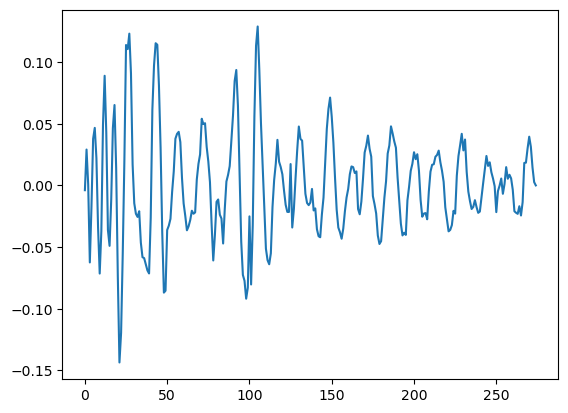

In [1]:
"""
Script to process all the LCDRI data, generate 1D surface wave spectra, and calculate significant wave heights

"""


from scipy.io import loadmat, savemat
from scipy import signal
from scipy.io import netcdf
import numpy as np
import time
import pyIGRF
import datetime
import pandas as pd
import matplotlib.pyplot as plt
#from wavesim1d import *
from src.em_apex_processing import *
from src.spectral_processing import *
import os
import warnings



#########################
#####Define Constants####
#########################
Cmax=10
uVpc = 1e6 * (10e-3 / (2**24))

#Degree of polynomial fit
Nfit=1

nstep_off=25
navg_off=50
base_fr=0.02

ch=0.06
cz=0.09

nstep = 60
navg = 120 
Zmax=100
Dirmax=80
#electrode separation
esep1 = (8+5/8)*0.0254 # m
esep2 = (8+5/8)*0.0254 # m
c1 = 0.5
c2 = -0.2
# angles between compass and electrode axes
alpha2 = 1.95
alpha1 = alpha2 - np.pi/2
###########################


nblock = 120
fs = 1
overlap = 60

### Load Files ###
#For loading from harddrive
#fname_base = "/Volumes/TFO-5TB-3/TFO/LCDRI/raw_data/"
#For loading from laptop
fname_base = "/Users/jamesstadler/Documents/UW/TFO/Data/LCDRI/EmApex_Data/lcdri/"
save_dir = "/Volumes/TFO-5TB-3/TFO/LCDRI/processed_data/James_output/Spectra/"
float_list = os.listdir(fname_base)

#Initialize arrays for storing stuff
big_spec_store = []
big_time_store = []
big_up_down_store = []
big_prof_store = []
big_uncertainty_store = []
big_loc_store = []
big_prof_speed_store = []
big_rotf_store = []
resid_store = np.array([])

#For investigating down profiles
#down_min_z = []
#up_min_z =[]

up_count = 0
down_count = 0
up = True

float_id_counter = 0
ignore_count = 0
too_deep_counter = 0
min_bin = []
first_bot = []

##Testing for nans -- TO DO: Think we can delete this nan stuff
nancounter = 0
nanstorer = []
for float_id in float_list:
    
    if "grid" in float_id:
        continue
    if ".DS_" in float_id:
        continue
        
    dec_name = fname_base+float_id+"/dec/"
    
    #Loop through each profile for that float
    files = os.listdir(dec_name)
    efr_files = [file for file in files if "efr.mat" in file and not file.startswith('.')]
    
    spec_store = np.zeros((len(efr_files), 2 , (nblock//2)-1))
    time_store = np.zeros(len(efr_files))
    up_down_store = np.zeros(len(efr_files))
    prof_speed_store = np.zeros(len(efr_files))
    rotf_store = np.zeros(len(efr_files))
    uncertainty_store = np.zeros((len(efr_files), 3))
    loc_store = np.zeros((len(efr_files), 2))
    prof_store = np.empty(len(efr_files), dtype=object)
    counter=0
    #Load each profiling file, and then calculate the 1D spectrum
    for file in efr_files:
        fname = dec_name + file
        EFR = loadmat(fname)

        
        prof_num = int(file.split('-')[2])
        #Load the UXT times, and correct
        
        efr_times = EFR['UXT'] - EFR['AGE']
        efr_times = efr_times[0, :]
        seqno = EFR['SEQNO'][0, :]
        
        #Fit UXT times to sequence number (measurement # for that profile) to make sure monotonically increasing
        p = np.polyfit(seqno,efr_times,1)
        pfit = np.poly1d(p)
        mlt_efr = pfit(seqno);

        
        #Load GPS file for calculating 
        # gps files are only on up profiles (even)
        if prof_num%2==0:
            up = True
            cut = fname.find("efr")
            gpsfname = fname[:cut]+"gps.mat"
        else:
            up = False
            new_file = file.split('-')[0]+'-'+file.split('-')[1]+'-{:04d}'.format(prof_num+1)+'-gps.mat'
            gpsfname = dec_name+new_file
        GPS = loadmat(gpsfname)

        #Load CTD file 
        cut = fname.find("efr")
        ctdfname = fname[:cut]+"ctd.mat"
        CTD = loadmat(ctdfname)
        
        ctd_time = CTD["UXT"][0, :]
        P = CTD["P"][0, :]
        Pef = np.interp(mlt_efr, ctd_time, P)

        tim_pd = pd.to_datetime(GPS["UXT_GPS"][0, :],unit='s', utc=True,)
        #Convert time to fractional year for use in the igrf function
        frac_yrs = np.array([year_fraction(dt) for dt in tim_pd])
        avg_lat = np.nanmean(GPS["LAT"][0, :])
        avg_lon = np.nanmean(GPS["LON"][0, :])
        avg_frac_yrs = np.nanmean(frac_yrs)

        #Get magnetic field values
        [Bx, By, Bz, f] = pyIGRF.calculate.igrf12syn(avg_frac_yrs, 1, 0, avg_lat, avg_lon)
        #get conversion factor for converting to velocity
        fz=-np.nanmean(Bz);
        fh=np.nanmean(np.sqrt(Bx**2+By**2));
        sfv1 = 1e3/(fz*esep1*(1.0+c1));
        sfv2 = 1e3/(fz*esep2*(1.0+c1));
        
        #Convert from counts to microvolts
        E1 = (EFR["E1"][0, :]-2**23) * uVpc;
        E2 = (EFR["E2"][0, :]-2**23) * uVpc;
        
        #pull out compass values
        HZ = EFR["HZ"][0, :];
        HY = EFR["HY"][0, :];
        HX = EFR["HX"][0, :];
        
        
        #If up is true, flip everything
        if up:
            E1 = np.flip(E1)
            E2 = np.flip(E2)
            HZ = np.flip(HZ)
            HX = np.flip(HX)
            HY = np.flip(HY)
            Pef = np.flip(Pef)
            mlt_efr = np.flip(mlt_efr)
        
        else:
            #Do Nothing
            pass
            
        
        #Remove the beginning of the timesereis before the float starts moving
        #Need to do this for all of E1, E2, HX, HY, mlt_efr
        moving_inds = get_moving_inds(Pef)
        
        #Uncomment this to print out the filenames where EM starts before CTD
        #if len(moving_inds)<len(Pef):
            #print(len(Pef)-len(moving_inds), fname)
            #continue
            
        #Apply moving_inds to the EM timeseries
        E1 = E1[moving_inds]
        E2 = E2[moving_inds]
        HX = HX[moving_inds]
        HY = HY[moving_inds]
        mlt_efr = mlt_efr[moving_inds]
        Pef = Pef[moving_inds]
        
        #[HX, HY] = correct_magnetometer(HX, HY)
        
        #a,b = signal.butter(1, 0.04, 'hp', fs=1, analog=False)
        #E1_filtered = signal.filtfilt(a, b, E1)
        #E2_filtered = signal.filtfilt(a, b, E2)
        
        #Do the 50s fits 
        [e1offs,e2offs,e1fits,e2fits,anghxhy, resid] = em_offset(Nfit,mlt_efr,nstep_off,navg_off,E1,E2,HX,HY);

        #Get overall fi and calculate the residuals
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=RuntimeWarning)
            e1off=np.nanmean(e1offs,1);
            e2off=np.nanmean(e2offs,1);
            e1fit=np.nanmean(e1fits,1);
            e2fit=np.nanmean(e2fits,1);
            resid = np.nanmean(resid,1);

        #Calculate the residual
        e1r = E1 - e1fit
        e2r = E2 - e2fit

        ## Do spike detection
        #If either channel has spikes, ignore the profile.
        spikes=contains_spikes(E1, E2)
        if spikes:
            print(fname)
            continue
        
        
        #Now need to convert to velocity (m/s)
        e1r = e1r*sfv1
        e2r = e2r*sfv2
        

        #Now use the angles to rotate to x-y coordinates
        avg_angs = np.copy(anghxhy)
        avg_angs[~np.isnan(avg_angs)] = np.unwrap(avg_angs[~np.isnan(avg_angs)])
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=RuntimeWarning)
            avg_angs = np.nanmean(avg_angs, axis=1)


        E2_r=e2r*np.cos(avg_angs)+e1r*np.sin(avg_angs);
        E1_r=-e2r*np.sin(avg_angs)+e1r*np.cos(avg_angs);

        E_x = E1_r*np.cos(alpha1)-E2_r*np.sin(alpha1)
        E_y = E1_r*np.sin(alpha1)+E2_r*np.cos(alpha1)
        
        #Now try highpass filtering the data
        sos = signal.butter(10, 0.04, 'hp', fs=1, output='sos')
        E_x_filtered = signal.sosfilt(sos, E_x)
        E_y_filtered = signal.sosfilt(sos, E_y)
        
        E_x = E_x_filtered
        E_y = E_y_filtered
        
        
        
    
        ##Get the mean residual level below 90m for the purpose of estimating error
        deep_inds = np.where(Pef>=90)
        error = np.sqrt(np.square(e1r[deep_inds])+np.square(e2r[deep_inds]))
        resid_store = np.append(resid_store, error)
        
        
        #Now take the spectra

        
        #in the case where the float doesn't actually move for nblock measurements, need to skip it
        if len(E_x)<nblock:
            continue
        #If there's only one block worth of data, ignore the profile
        
      
        [u_x, z_x] = reshape_u(E_x, Pef, nblock, overlap, fs)
        [u_y, z_y] = reshape_u(E_y, Pef, nblock, overlap, fs)
        #prof_speed is a numpy array that stores the mean vertical velocity (in m/s)
        #for each spectral window
        #Throwaway to get t_new in the same shape as u_x and z_x for calculating mean profiling speed
        [u_x_temp, t_new] = reshape_u(E_x, mlt_efr, nblock, overlap, fs)
        
        prof_speed = np.abs(z_x[:, 0]-z_x[:, -1])/np.abs(t_new[:, 0]-t_new[:, -1])
        
        #if up:
        #    print(np.nanmean(prof_speed), "up")
        #else:
        #    print(np.nanmean(prof_speed), "down")
            
        if u_x.shape[0]==1:
            continue
        prof_speed_new = np.zeros(len(prof_speed))
        for block_ind in range(z_x.shape[0]):
            prof_speed_try = np.abs(np.gradient(z_x[block_ind, :], t_new[block_ind, :]))
            z_inds = prof_speed_try<0.001
            prof_speed_try[z_inds]=np.nan
            prof_speed_removed_zeros = np.nanmean(prof_speed_try)
            prof_speed_new[block_ind]=prof_speed_removed_zeros

        prof_speed = prof_speed_new
        
            
        #Get teh rotation frequency
        time_s = np.abs(mlt_efr - mlt_efr[0])
        rad_per_s = np.gradient(avg_angs, time_s) #radians per second. rotation period is 2pi/rad_per_s
        rotf = rad_per_s/2/np.pi
        
        [rotf_reshaped, _] = reshape_u(rotf, Pef, nblock, overlap, fs)
        
        window_rotf = np.nanmean(rotf_reshaped, axis=1)
        
        
        zero_inds = np.where(prof_speed==0)[0]
        #if len(zero_inds)>0:
            #print(z_x[0, :])
            
        UUwindow, fwindow = make_vel_spectrum(u_x, fs)

        VVwindow, fwindow = make_vel_spectrum(u_y, fs)

        min_z = np.min(Pef)
            
        if min_z>20:
            too_deep_counter+=1
        else:  
            min_bin = np.append(min_bin, min_z)
            first_bot = np.append(first_bot, z_x[0, -1])

            UU = UUwindow/(int(nblock/2)*fs)
            Exx = UU[:,1:]/ (np.square((2*np.pi*fwindow[1:])))
            VV = VVwindow/(int(nblock/2)*fs)
            Eyy = VV[:,1:]/ (np.square((2*np.pi*fwindow[1:])))

            Eh = Exx+Eyy
            
            if np.isnan(np.nanmean(np.nanmean(Eh, axis=0))):
                #print("All NaNs!!")
                if nancounter==0:
                    #plt.loglog(fwindow, np.transpose(VVwindow))
                    #plt.plot(np.transpose(u_y))
                    #plt.loglog(fwindow[1:], np.transpose(Eh))
                    print(make_vel_spectrum(u_y, fs))
                    
                temp1 = np.expand_dims(np.array(E_x), axis=0)
                temp2 = np.expand_dims(np.array(E_y), axis=0)
                temp3 = np.append(temp1, temp2, axis=0)
                nanstorer.append(temp3)
                #if nancounter<10:
                #    plt.figure()
                #    plt.plot(E_x)
                #    plt.plot(E_y)
                nancounter+=1
                
            [Eh_Eric1, Eh_Eric2, Eh_Eric3, Eh_Eric4] = depth_correct_Eric(Eh, fwindow[1:], z_x, prof_speed, nblock, Cmax, fs)
            G1 = Eh_Eric2/Eh_Eric1
            G2 = Eh_Eric3/Eh_Eric2
            G3 = Eh_Eric4/Eh_Eric3
            
            if prof_num%2==0 & up_count==0:
                
                k_array = np.square(2*np.pi*fwindow[1:])/9.8
                k_mat = np.tile(k_array, (Eh.shape[0], 1))
                z_mat = z_x
                z_mat = np.tile(np.expand_dims(np.nanmedian(z_mat, axis=1), axis=1), (1, len(k_mat[0, :])))
                prof_speed_u = np.tile(np.expand_dims(prof_speed_new, axis=1), (1, Eh.shape[1]))
                kWT2_up = 1*k_mat*prof_speed_u*(nblock/fs)
                up_count=1
                
                #print(np.nanmean(G1), np.nanmean(G2), np.nanmean(G3), "up")
            else:
                if down_count==0:
                    k_array = np.square(2*np.pi*fwindow[1:])/9.8
                    k_mat = np.tile(k_array, (Eh.shape[0], 1))
                    z_mat = z_x
                    z_mat = np.tile(np.expand_dims(np.nanmedian(z_mat, axis=1), axis=1), (1, len(k_mat[0, :])))
                    prof_speed_d = np.tile(np.expand_dims(prof_speed_new, axis=1), (1, Eh.shape[1]))
                    kWT2_down = 1*k_mat*prof_speed_d*(nblock/fs)
                    down_count=1
                #print(np.nanmean(G1), np.nanmean(G2), np.nanmean(G3), "down")
                
            if np.isnan(Eh_Eric4).all():
                continue
                #Then what happens is the float never moved?
                #What if we just try applying the depth correction
                k_array = np.square(2*np.pi*fwindow[1:])/9.8
                k_mat = np.tile(k_array, (Eh.shape[0], 1))

                #This is def not the easiest way to do this
                #z_mat = np.tile(em_z, (Eh.shape[0], 1))
                z_mat = z_x
                z_mat = np.tile(np.expand_dims(np.nanmedian(z_mat, axis=1), axis=1), (1, len(k_mat[0, :])))
                #print(z_mat)


                depth_fact = np.exp(2*k_mat*z_mat)
                depth_fact[np.exp(k_mat*z_mat)>Cmax]=np.nan
                #depth_fact[depth_fact>Cmax]=np.nan
                Eh_Eric4 = Eh*depth_fact
            
            u_noise = 0 #This is just for testing...
            [lbound, ubound, nu] = get_spectral_uncertainity(E_x, E_y, Pef, u_noise, prof_speed, nblock, overlap, Cmax, fs)
            #print(lbound)
            #print(ubound)
            #Try propogating errors through and see if this has a different result
            #Eh_lbound = Eh*lbound
            #Eh_ubound = Eh*ubound
            
            if ubound>5:
                print(prof_num)
                plt.plot(E_x)
                get_spectral_uncertainity(E_x, E_y, Pef, u_noise, prof_speed, nblock, overlap, Cmax, fs, debug_flag=True)
                print(u_x.shape)
            #[_, _, _, Eh_Eric4_lbound] = depth_correct_Eric(Eh_lbound, fwindow[1:], z_x, prof_speed, nblock, Cmax, fs)
            #[_, _, _, Eh_Eric4_ubound] = depth_correct_Eric(Eh_ubound, fwindow[1:], z_x, prof_speed, nblock, Cmax, fs)


            #lbound = Eh_Eric4_lbound/Eh_Eric4
            #ubound = Eh_Eric4_ubound/Eh_Eric4
            
            #Average each profile spec and add to the storer
            with warnings.catch_warnings():
                warnings.simplefilter("ignore", category=RuntimeWarning)
                spec_store[counter, 0, :] = np.nanmean(Eh, axis=0)
                spec_store[counter, 1, :] = np.nanmean(Eh_Eric4, axis=0)
                prof_speed_store[counter] = np.nanmean(prof_speed)
                rotf_store[counter]=np.nanmean(window_rotf)
                time_store[counter] = np.nanmean(mlt_efr)
                prof_store[counter] = float_id+"_"+str(prof_num)
                
                uncertainty_store[counter, :] = np.array([lbound, ubound, nu])
                loc_store[counter, :] = np.array([avg_lat, avg_lon])
                if prof_num%2==0:
                    #Then it's even and its an up profile
                    up_down_store[counter] = 1
                else:
                    up_down_store[counter] = 0

        
        
            counter+=1
        
        
    
    # Now store each one in a big array for sorting etc later
    if float_id_counter==0:
        big_spec_store=spec_store
        big_uncertainty_store = uncertainty_store
        big_time_store = time_store
        big_up_down_store = up_down_store
        big_prof_store = prof_store
        big_loc_store = loc_store
        big_prof_speed_store = prof_speed_store
        big_rotf_store = rotf_store
    else:
        big_spec_store = np.append(big_spec_store, spec_store, axis=0)
        big_uncertainty_store = np.append(big_uncertainty_store,uncertainty_store, axis=0)
        big_time_store = np.append(big_time_store, time_store)
        big_up_down_store = np.append(big_up_down_store, up_down_store)
        big_prof_store = np.append(big_prof_store, prof_store)
        big_prof_speed_store = np.append(big_prof_speed_store, prof_speed_store)
        big_rotf_store = np.append(big_rotf_store, rotf_store)
        big_loc_store = np.append(big_loc_store, loc_store, axis=0)
        

    
    float_id_counter+=1
        
    #np.save(save_dir+float_id, spec_store)


In [2]:
#Cell for sorting the arrays by time

cdip_color='#F5B958'
red_color = '#D81159'
gray_color= '#2E2836'

#Getting rid of the profiles where minimum depth was below 20m
kill = np.where(big_spec_store[:, 0, 5]==0)


spec_store_shallow = np.delete(big_spec_store, kill[0], axis=0)
time_store_shallow = np.delete(big_time_store, kill[0], axis=0)
up_down_store_shallow = np.delete(big_up_down_store, kill[0], axis=0)
prof_store_shallow = np.delete(big_prof_store, kill[0], axis=0)
uncertainty_store_shallow = np.delete(big_uncertainty_store, kill[0], axis=0)
loc_store_shallow = np.delete(big_loc_store, kill[0], axis=0)
big_prof_speed_shallow = np.delete(big_prof_speed_store, kill[0], axis=0)
big_rotf_shallow = np.delete(big_rotf_store, kill[0], axis=0)

out = zip(spec_store_shallow, up_down_store_shallow, time_store_shallow, prof_store_shallow)
out2 = zip(uncertainty_store_shallow, time_store_shallow, loc_store_shallow,big_prof_speed_shallow, big_rotf_shallow)
#list(out)[0]
sorted_array = sorted(out, key=lambda tup: tup[2])
sorted_array2 = sorted(out2, key=lambda tup: tup[1])

unzipped = ([ a for a,b,c,d in sorted_array ], [ b for a,b,c,d in sorted_array ], [c for a,b,c,d in sorted_array], [d for a,b,c,d in sorted_array])
unzipped2 = ([ a for a,b,c,d,e in sorted_array2 ], [ b for a,b,c,d,e in sorted_array2 ], [c for a,b,c,d,e in sorted_array2], [d for a,b,c,d,e in sorted_array2], [e for a,b,c,d,e in sorted_array2])

spec_store_sorted = np.array(unzipped[0])
up_down_store_sorted = np.array(unzipped[1])
time_store_sorted = np.array(unzipped[2])
prof_store_sorted = np.array(unzipped[3])

uncertainty_store_sorted = np.array(unzipped2[0])
loc_store_sorted = np.array(unzipped2[2])
prof_speed_store_sorted = np.array(unzipped2[3])
rotf_store_sorted = np.array(unzipped2[4])

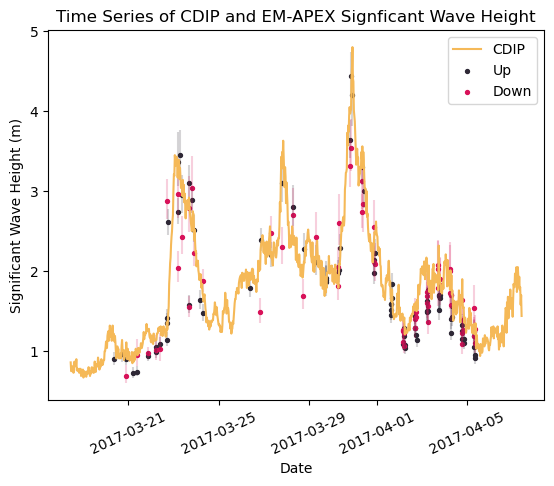

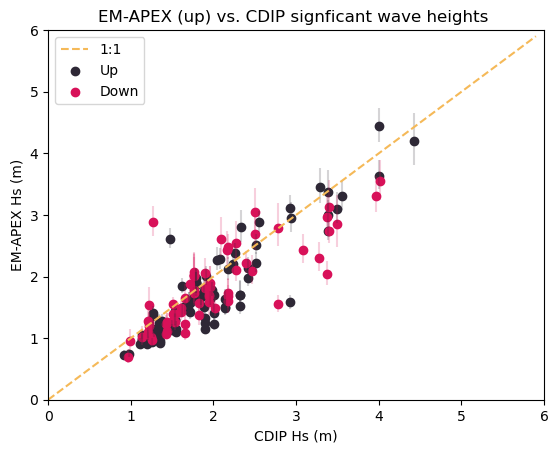

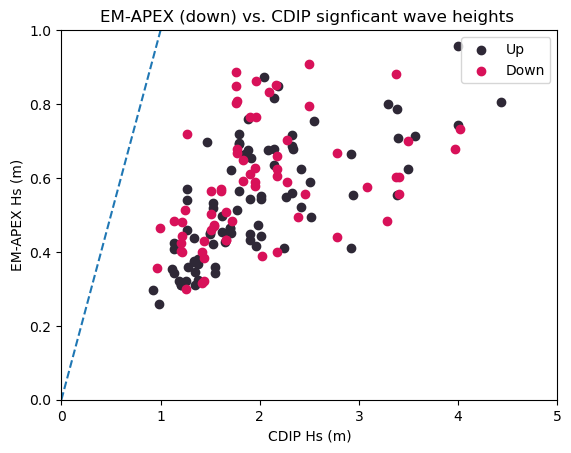

In [3]:
#Cell for plotting time series of significant wave heights and scatter plots of cdip vs. EM-APEX

spec_store_sorted_new_raw = spec_store_sorted[:, 0, :]
spec_store_sorted_new_corr = spec_store_sorted[:, 1, :]

spec_store_sorted_new_corr = add_hf_tail(spec_store_sorted_new_corr, fwindow[1:])
sig_wave_array = [];

[Hs,lower,upper] = sig_wave_height(fwindow, np.transpose(spec_store_sorted_new_raw))
[Hs_corr, lower, upper] = sig_wave_height(fwindow, np.transpose(spec_store_sorted_new_corr), uncertainty_store_sorted)

errors = np.zeros((2, len(lower)))
errors[0,:]=lower
errors[1,:]=upper

t_apex = np.array([datetime.datetime.fromtimestamp(t) for t in time_store_sorted])

ups = np.where(up_down_store_sorted==1)[0]
downs = np.where(up_down_store_sorted==0)[0]

#plt.plot(t_apex, Hs, color='k', linewidth=1, alpha=0.5, label='EM-APEX raw')
plt.scatter(t_apex[ups], Hs_corr[ups], color=gray_color, s=8, label='Up')
plt.scatter(t_apex[downs], Hs_corr[downs], color=red_color, s=8, label='Down', )
plt.errorbar(t_apex[ups], Hs_corr[ups], yerr = errors[:, ups], color=gray_color, alpha=0.2, fmt='none')
plt.errorbar(t_apex[downs], Hs_corr[downs], yerr = errors[:, downs], color=red_color, alpha=0.2, fmt='none')


#plt.plot(t_apex, Hs_corr, '--C4', label='EM-APEX corrected')


fname = "/Users/jamesstadler/Documents/UW/TFO/Data/LCDRI/229p1_d01.nc"

nc = netcdf.NetCDFFile(fname, 'r', mmap=False) #Not sure why I need to do mmap = False but it gets rid of a warning
times = nc.variables['waveTime'][:]
ts = np.array([datetime.datetime.fromtimestamp(t) for t in times])
Hs_cdip = nc.variables['waveHs'][:]
energy_density = nc.variables['waveEnergyDensity'][:]
wave_freq = nc.variables['waveFrequency'][:]
cdip_lat = np.nanmean(nc.variables['gpsLatitude'][:])
cdip_lon = np.nanmean(nc.variables['gpsLongitude'][:])

#dtimes = datetime(time, 'convertfrom', 'posixtime');
nc.close()
plt.plot(ts, Hs_cdip, label='CDIP', color='#F5B958')

#plt.scatter(swift_t_out, swift_arr[:, 3], s=6, alpha=0.2, color='k')

plt.ylabel("Significant Wave Height (m)")
plt.xlabel('Date')
plt.xticks( rotation=25 )
plt.title("Time Series of CDIP and EM-APEX Signficant Wave Height")
plt.legend()

#plt.savefig("/Users/jamesstadler/Documents/UW/TFO/Figures/LCDRI/JTECH_Paper/CDIP_EM_Hs_Timeseries.png", bbox_inches='tight')


##Get Errors
#first need to match up teh 
cdip_inds = np.array([], dtype=int)
for ind in range(0, len(time_store_sorted[ups])):
    ind2 = np.where(np.abs(time_store_sorted[ups][ind]-times)==np.min(np.abs(time_store_sorted[ups][ind]-times)))
    #plt.loglog(wave_freq, energy_density[ind2[0][0], :], label="CDIP")
    cdip_inds = np.append(cdip_inds, ind2[0])

    
cdip_inds_down = np.array([], dtype=int)
for ind in range(0, len(time_store_sorted[downs])):
    ind2 = np.where(np.abs(time_store_sorted[downs][ind]-times)==np.min(np.abs(time_store_sorted[downs][ind]-times)))
    #plt.loglog(wave_freq, energy_density[ind2[0][0], :], label="CDIP")
    cdip_inds_down = np.append(cdip_inds_down, ind2[0])
    
errs = Hs_corr[ups] - Hs_cdip[cdip_inds]

np.where(errs==np.max(errs))


#Up figure
plt.figure()
plt.errorbar(Hs_cdip[cdip_inds], Hs_corr[ups], yerr = errors[:, ups], color=gray_color, alpha=0.2, fmt='none')
plt.scatter(Hs_cdip[cdip_inds], Hs_corr[ups], color=gray_color, label="Up")

plt.errorbar(Hs_cdip[cdip_inds_down], Hs_corr[downs], yerr = errors[:, downs], color=red_color, alpha=0.2, fmt='none')
plt.scatter(Hs_cdip[cdip_inds_down], Hs_corr[downs], color=red_color, label="Down")



y = np.arange(0, 6, 0.1)
plt.plot(np.arange(0, 6, 0.1), y, '--',color=cdip_color, label="1:1")
plt.xlim([0, 6])
plt.ylim([0, 6])
plt.xlabel("CDIP Hs (m)")
plt.ylabel("EM-APEX Hs (m)")
plt.title("EM-APEX (up) vs. CDIP signficant wave heights ")
plt.legend()
#plt.savefig("/Users/jamesstadler/Documents/UW/TFO/Figures/LCDRI/JTECH_Paper/APEX_vs_CDIP_hs.png", bbox_inches='tight')






plt.figure()
plt.scatter(Hs_cdip[cdip_inds], Hs[ups], color=gray_color, label="Up")
plt.scatter(Hs_cdip[cdip_inds_down], Hs[downs], color=red_color, label="Down")

y = np.arange(0, 5, 0.1)
plt.plot(np.arange(0, 5, 0.1), y, '--')
plt.xlim([0, 5])
plt.ylim([0, 1])
plt.xlabel("CDIP Hs (m)")
plt.ylabel("EM-APEX Hs (m)")
plt.title("EM-APEX (down) vs. CDIP signficant wave heights ")
plt.legend()

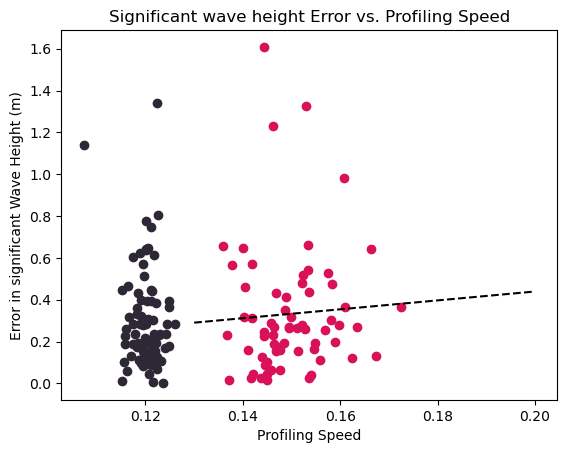

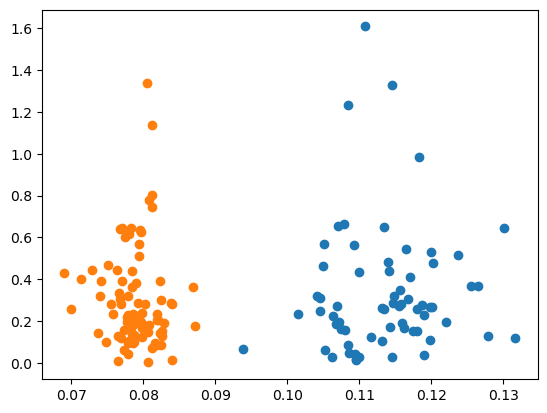

In [4]:
down_errs = np.abs(Hs_corr[downs] - Hs_cdip[cdip_inds_down])
up_errs = np.abs(Hs_corr[ups] - Hs_cdip[cdip_inds])
plt.figure()

#Fit the down stuff
[coef, resid, rank, sing, rcond] = np.polyfit(prof_speed_store_sorted[downs],down_errs,1, full=True)
poly1d_fn = np.poly1d(coef) 
# poly1d_fn is now a function which takes in x and returns an estimate for y

x=np.linspace(0.13, 0.2, 25)
plt.plot(x, poly1d_fn(x), '--k') #'--k'=black dashed line, 'yo' = yellow circle marker


plt.scatter(prof_speed_store_sorted[ups], up_errs, color=gray_color)
plt.xlabel("Profiling Speed")
plt.ylabel("Error in significant Wave Height (m)")




plt.scatter(prof_speed_store_sorted[downs], down_errs, color=red_color)


#plt.scatter(prof_speed_store_sorted[ups], up_errs, color=gray_color)

plt.title("Significant wave height Error vs. Profiling Speed")

plt.figure()
plt.scatter(rotf_store_sorted[downs], down_errs)
plt.scatter(rotf_store_sorted[ups], up_errs)
#prof_speed_store_sorted.shape

[[1.         0.90967856]
 [0.90967856 1.        ]]
[[1.         0.81841401]
 [0.81841401 1.        ]]


/var/folders/77/7yfflvs902s95j6rlhb5yn9c0000gn/T/ipykernel_57520/4048644213.py:18: DeprecationWarning: scipy.corrcoef is deprecated and will be removed in SciPy 2.0.0, use numpy.corrcoef instead
  print(scipy.corrcoef(Hs_cdip[cdip_inds], Hs_corr[ups]))
/var/folders/77/7yfflvs902s95j6rlhb5yn9c0000gn/T/ipykernel_57520/4048644213.py:19: DeprecationWarning: scipy.corrcoef is deprecated and will be removed in SciPy 2.0.0, use numpy.corrcoef instead
  print(scipy.corrcoef(Hs_cdip[cdip_inds_down], Hs_corr[downs]))


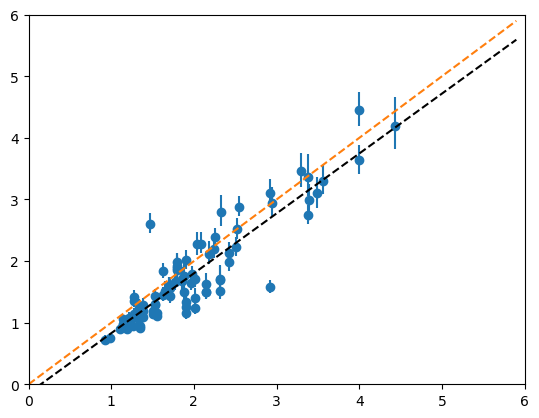

In [5]:
#Plot best fit line to up data
plt.scatter(Hs_cdip[cdip_inds], Hs_corr[ups])
plt.errorbar(Hs_cdip[cdip_inds], Hs_corr[ups], yerr = errors[:, ups], fmt='none')

x=np.arange(0, 6, 0.1)
y = np.arange(0, 6, 0.1)
plt.plot(x, y, '--')
plt.xlim([0, 6])
plt.ylim([0, 6])



[coef, resid, rank, sing, rcond] = np.polyfit(Hs_cdip[cdip_inds], Hs_corr[ups],1, full=True)
poly1d_fn = np.poly1d(coef) 
# poly1d_fn is now a function which takes in x and returns an estimate for y

plt.plot(x, poly1d_fn(x), '--k') #'--k'=black dashed line, 'yo' = yellow circle marker
print(scipy.corrcoef(Hs_cdip[cdip_inds], Hs_corr[ups]))
print(scipy.corrcoef(Hs_cdip[cdip_inds_down], Hs_corr[downs]))


In [6]:
#Get distances from buoy to floats
dist=np.array([])
import haversine
for ind in range(big_loc_store.shape[0]):
    lat = big_loc_store[ind, 0]
    lon = big_loc_store[ind, 1]
    #In meters
    dist = np.append(dist, np.array(haversine.haversine((lat, lon), (cdip_lat, cdip_lon)))/1000)
    

In [8]:
#Loop through and calculate mean percent error at all freqeuencies and also rotation freqeuecny
#for spec_index in range(spec_store_sorted[:, 1, :].shape[0]):
#interpolate waverider to same bins
wave_energy_interped = np.zeros((len(cdip_inds), len(fwindow[3:])))
for ind_num in range(len(cdip_inds)):
    wave_energy_interped[ind_num, :] = np.interp(fwindow[3:], wave_freq, energy_density[cdip_inds[ind_num], :])
#spec_store_sorted[:, 1, :]-wave_energy

diff=(spec_store_sorted[:, 1, 2:]-wave_energy_interped)
diff.shape


plt.plot(fwindow[3:], np.nanmean(diff, axis=0))

#now get rotation frequency index
diff_store = np.zeros(len(rotf_store_sorted), dtype='int')
for i in range(len(rotf_store_sorted)):
    rotf_ind = np.where(np.abs(rotf_store_sorted[i]-fwindow[3:])==np.min(np.abs(rotf_store_sorted[i]-fwindow[3:])))[0]
    diff_store[i] = spec_store_sorted[i, 1, rotf_ind-1]-wave_energy_interped[i, rotf_ind]
    #cdip_find2 = np.where(np.abs(1/rotp_store_sorted[ind]-wave_freq)==np.min(np.abs(1/rotp_store_sorted[ind]-wave_freq)))[0]

#diff_rotf = spec_store_sorted[:, 1, rotf_inds-1]-wave_energy_interped[:, rotf_inds]
plt.figure()
plt.plot(diff_store)
print(np.nanmean(diff))
print(np.nanmean(diff_store))
#pltnp.nanmean(diff, axis=0).shape
#rotf_inds
#spec_store_sorted[:, 1, rotf_inds-1].shape

ValueError: operands could not be broadcast together with shapes (151,57) (85,57) 

(151,)
(151,)
[0.1        0.06666667 0.06666667 0.06666667 0.06666667 0.06666667
 0.11666667 0.06666667 0.06666667 0.06666667 0.06666667 0.06666667
 0.06666667 0.06666667 0.05       0.06666667 0.14166667 0.06666667
 0.16666667 0.15833333 0.13333333 0.125      0.125      0.125
 0.11666667 0.125      0.06666667 0.15833333 0.06666667 0.13333333
 0.09166667 0.125      0.15833333 0.125      0.13333333 0.06666667
 0.1        0.15       0.09166667 0.1        0.16666667 0.21666667
 0.125      0.11666667 0.1        0.11666667 0.05833333 0.05833333
 0.05833333 0.05833333 0.06666667 0.06666667 0.06666667 0.06666667
 0.06666667 0.06666667 0.06666667 0.06666667 0.06666667 0.14166667
 0.11666667 0.11666667 0.11666667 0.10833333 0.13333333 0.09166667
 0.1        0.09166667 0.1        0.09166667 0.09166667 0.11666667
 0.11666667 0.08333333 0.1        0.08333333 0.08333333 0.10833333
 0.08333333 0.075      0.09166667 0.075      0.075      0.08333333
 0.125      0.075      0.11666667 0.075      0.075   

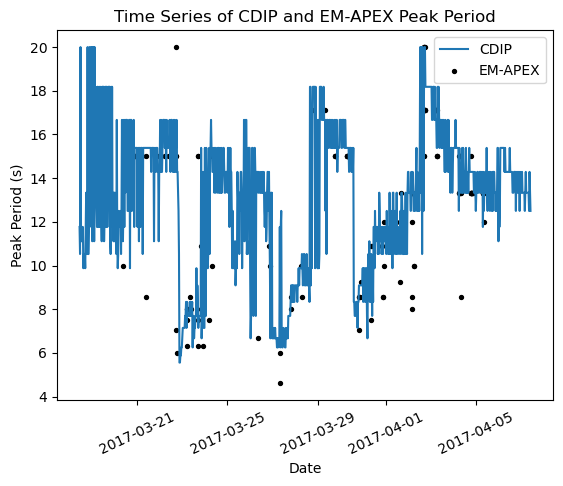

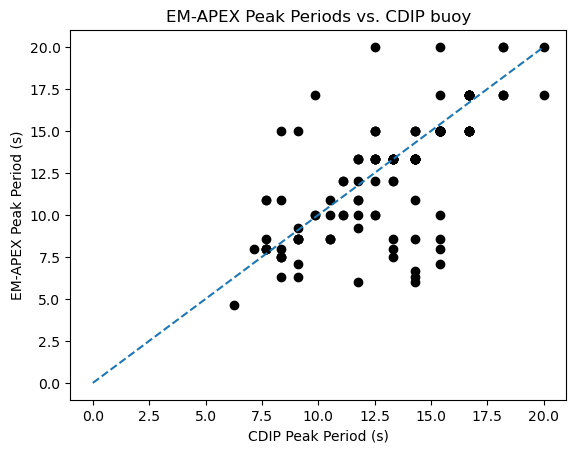

In [7]:
#Cell for plotting peak frequency time series for both CDIP and EM-APEX buoys
[peak_freq, peak_spl] = get_peak_freq(fwindow[1:], spec_store_sorted_new_corr)
plt.scatter(t_apex, 1/peak_freq, color='k', s=8, label="EM-APEX")

[peak_freq_cdip, peak_spl_cdip] = get_peak_freq(wave_freq, energy_density)

plt.plot(ts, 1/peak_freq_cdip, label="CDIP")
plt.ylabel("Peak Period (s)")
plt.xlabel('Date')
plt.xticks( rotation=25 )
plt.title("Time Series of CDIP and EM-APEX Peak Period")
plt.legend()

cdip_inds = np.array([], dtype=int)
for ind in range(0, len(time_store_sorted)):
    ind2 = np.where(np.abs(time_store_sorted[ind]-times)==np.min(np.abs(time_store_sorted[ind]-times)))
    #plt.loglog(wave_freq, energy_density[ind2[0][0], :], label="CDIP")
    cdip_inds = np.append(cdip_inds, ind2[0])
    
plt.figure()
plt.scatter(1/peak_freq_cdip[cdip_inds], 1/peak_freq, color='k', label="Ups")
#plt.scatter(1/peak_freq_cdip[cdip_inds][downs], 1/peak_freq[downs], color='r', label="Downs'")
#plt.errorbar(Hs_cdip[cdip_inds], Hs_corr[ups], yerr = errors[:, ups], fmt='none')
print(peak_freq.shape)
print(peak_freq_cdip[cdip_inds].shape)

cdip_inds

#y = np.arange(0, 0.225, 0.001)
#plt.plot(np.arange(0, 0.225, 0.001), y, '--')
y = np.arange(0, 20, 0.1)
plt.plot(np.arange(0, 20, 0.1), y, '--')
#plt.xlim([0, 6])
#plt.ylim([0, 6])
plt.xlabel("CDIP Peak Period (s)")
plt.ylabel("EM-APEX Peak Period (s)")
plt.title("EM-APEX Peak Periods vs. CDIP buoy")




#Calculate weighted energy period
print(peak_freq)


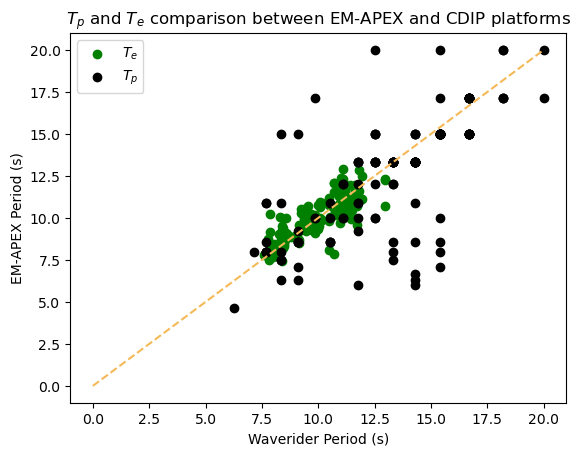

In [12]:
num = np.trapz(spec_store_sorted_new_corr, x=fwindow[1:])
denom = np.trapz(fwindow[1:]*spec_store_sorted_new_corr, x=fwindow[1:])
Te = num/denom

num_cdip = np.trapz(energy_density, x=wave_freq)
denom_cdip = np.trapz(wave_freq*energy_density, x=wave_freq)
Te_cdip = num_cdip/denom_cdip


start_freq = 0.05
cutoff_freq = 0.2
end_f = np.where(fwindow[1:]<cutoff_freq)[-1][-1]
start_f = np.where(fwindow[1:]>start_freq)[0][0]
end_f_cdip  =np.where(wave_freq<cutoff_freq)[-1][-1]
start_f_cdip  =np.where(wave_freq>start_freq)[0][0]
num = np.trapz(spec_store_sorted_new_corr[:, start_f:end_f-1], x=fwindow[1+start_f:end_f])
denom = np.trapz(fwindow[1+start_f:end_f]*spec_store_sorted_new_corr[:, start_f:end_f-1], x=fwindow[1+start_f:end_f])
Te_cutoff = num/denom

num_cdip = np.trapz(energy_density[:, start_f_cdip:end_f_cdip], x=wave_freq[start_f_cdip:end_f_cdip])
denom_cdip = np.trapz(wave_freq[start_f_cdip:end_f_cdip]*energy_density[:, start_f_cdip:end_f_cdip], x=wave_freq[start_f_cdip:end_f_cdip])
Te_cdip_cutoff = num_cdip/denom_cdip

plt.scatter(Te_cdip_cutoff[cdip_inds], Te_cutoff, color='g', label=r"$T_{e}$")
plt.scatter(1/peak_freq_cdip[cdip_inds], 1/peak_freq, color='k', label=r"$T_{p}$")
#plt.scatter(Te_cdip[cdip_inds], Te, color='g', label="No cutoff")

y = np.arange(0, 20, 0.1)
plt.plot(np.arange(0, 20, 0.1), y, '--', color=cdip_color)
plt.xlabel("Waverider Period (s)")
plt.ylabel("EM-APEX Period (s)")
plt.title(r"$T_{p}$ and $T_{e}$ comparison between EM-APEX and CDIP platforms")
plt.legend()
#plt.savefig("/Users/jamesstadler/Documents/UW/TFO/Figures/LCDRI/JTECH_Paper/Frequency_plot.png", bbox_inches='tight')

#plt.figure()
#plt.plot(ts, Te_cdip)
#plt.scatter(t_apex, Te, color='k')


4

In [27]:
#Calculate correlation coefficients and biases
print(np.corrcoef(Te_cdip_cutoff[cdip_inds], Te_cutoff))
print(np.nanmean(Te_cutoff-Te_cdip_cutoff[cdip_inds]))
print(np.nanstd(Te_cutoff-Te_cdip_cutoff[cdip_inds])/np.sqrt(len(Te_cutoff)))

print(np.corrcoef(1/peak_freq, 1/peak_freq_cdip[cdip_inds]))
print(np.nanmean(1/peak_freq - 1/peak_freq_cdip[cdip_inds]))
print(np.nanstd(1/peak_freq - 1/peak_freq_cdip[cdip_inds])/np.sqrt(len(peak_freq)))

[[1.         0.81082949]
 [0.81082949 1.        ]]
0.29790541293768785
0.06892253050176603
[[1.         0.71817924]
 [0.71817924 1.        ]]
-0.5764376023835127
0.19852124682137676


6675g_22
3.0643891205126894 3.73591794962588
[3.0592226755370797, 3.743644020999131]


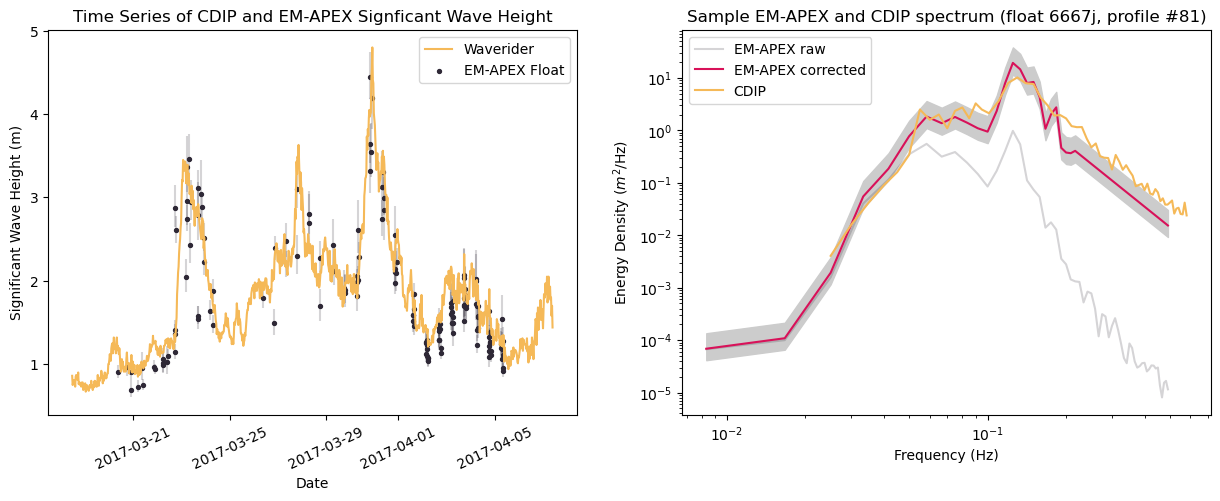

In [8]:
#Cell for checking individual spectra. Just change "ind" to whatever spectra you want to look at (sorted by time)
%matplotlib inline
#ind = 68 #This is the bad one
#ind = 22 # This is the one for hte figure in the paper
ind=112
ind=22
plt.figure(figsize=(15,5))
plt.subplot(122)
plt.fill_between(fwindow[1:],spec_store_sorted_new_corr[ind, :]*uncertainty_store_sorted[ind, 1],spec_store_sorted_new_corr[ind, :]*uncertainty_store_sorted[ind, 0],color='0.8')
#plt.fill_between(fwindow[1:],uncertainty_store_sorted[ind, 1],uncertainty_store_sorted[ind, 0],color='0.8')
plt.loglog(fwindow[1:], spec_store_sorted_new_raw[ind, :], label="EM-APEX raw", color=gray_color, alpha=0.2)
plt.loglog(fwindow[1:], spec_store_sorted_new_corr[ind, :], label="EM-APEX corrected", color=red_color)
plt.xlabel("Frequency (Hz)")
plt.ylabel(r"Energy Density ($m^2$/Hz)")

ind2 = np.where(np.abs(t_apex[ind]-ts)==np.min(np.abs(t_apex[ind]-ts)))
plt.loglog(wave_freq, energy_density[ind2[0][0], :], label="CDIP", color=cdip_color)


plt.legend()

plt.title("Sample EM-APEX and CDIP spectrum (float 6667j, profile #81)")
print(prof_store_sorted[ind])

plt.subplot(121)
plt.scatter(t_apex, Hs_corr, color=gray_color, s=8, label='EM-APEX Float')
#plt.scatter(t_apex[downs], Hs_corr[downs], color=red_color, s=8, label='Down', )
plt.errorbar(t_apex, Hs_corr, yerr = errors, color=gray_color, alpha=0.2, fmt='none')
#plt.errorbar(t_apex[downs], Hs_corr[downs], yerr = errors[:, downs], color=red_color, alpha=0.2, fmt='none')

plt.plot(ts, Hs_cdip, label='Waverider', color='#F5B958')

#plt.scatter(swift_t_out, swift_arr[:, 3], s=6, alpha=0.2, color='k')

plt.ylabel("Significant Wave Height (m)")
plt.xlabel('Date')
plt.xticks( rotation=25 )
plt.title("Time Series of CDIP and EM-APEX Signficant Wave Height")
plt.legend()
#plt.savefig("/Users/jamesstadler/Documents/UW/TFO/Figures/LCDRI/Timeseries_spectrum_test.png", bbox_inches='tight')
#plt.savefig("/Users/jamesstadler/Documents/UW/TFO/Figures/LCDRI/JTECH_Paper/Timeseries_spectrum.png", bbox_inches='tight')
nu_s =2*11* np.square(np.sum(spec_store_sorted_new_corr[ind, :]))/np.sum(np.square(spec_store_sorted_new_corr[ind, :]))
import scipy
llim = np.sqrt(nu_s/scipy.stats.chi2.ppf(1-.05/2, df=nu_s))*Hs_corr[ind]
ulim = np.sqrt(nu_s/scipy.stats.chi2.ppf(.05/2, df=nu_s))*Hs_corr[ind]
print(Hs_corr[ind]-errors[0, ind], Hs_corr[ind]+errors[1, ind])
print([llim, ulim])

3.0643891205126894 3.73591794962588
[3.0592226755370797, 3.743644020999131]


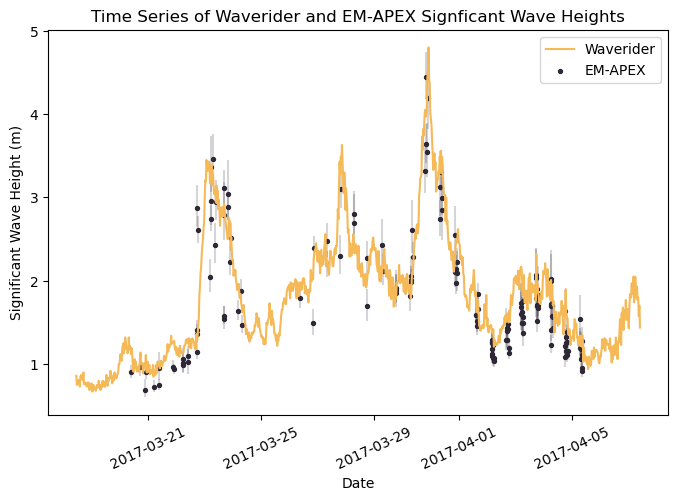

In [18]:
#Cell for checking individual spectra. Just change "ind" to whatever spectra you want to look at (sorted by time)
%matplotlib inline
#ind = 68 #This is the bad one
#ind = 22 # This is the one for hte figure in the paper
ind=112
ind=22
plt.figure(figsize=(8,5))


#plt.subplot(121)
plt.scatter(t_apex, Hs_corr, color=gray_color, s=8, label='EM-APEX')
#plt.scatter(t_apex[downs], Hs_corr[downs], color=red_color, s=8, label='Down', )
plt.errorbar(t_apex, Hs_corr, yerr = errors, color=gray_color, alpha=0.2, fmt='none')
#plt.errorbar(t_apex[downs], Hs_corr[downs], yerr = errors[:, downs], color=red_color, alpha=0.2, fmt='none')

plt.plot(ts, Hs_cdip, label='Waverider', color='#F5B958')

#plt.scatter(swift_t_out, swift_arr[:, 3], s=6, alpha=0.2, color='k')

plt.ylabel("Significant Wave Height (m)")
plt.xlabel('Date')
plt.xticks( rotation=25 )
plt.title("Time Series of Waverider and EM-APEX Signficant Wave Heights")
plt.legend()
#plt.savefig("/Users/jamesstadler/Documents/UW/TFO/Figures/LCDRI/Timeseries_spectrum_test.png", bbox_inches='tight')
#plt.savefig("/Users/jamesstadler/Documents/UW/TFO/Figures/LCDRI/JTECH_Paper/Timeseries_spectrum.png", bbox_inches='tight')
plt.savefig("/Users/jamesstadler/Documents/UW/TFO/Figures/LCDRI/JTECH_Paper/Timeseries_alone.png", bbox_inches='tight')
nu_s =2*11* np.square(np.sum(spec_store_sorted_new_corr[ind, :]))/np.sum(np.square(spec_store_sorted_new_corr[ind, :]))
import scipy
llim = np.sqrt(nu_s/scipy.stats.chi2.ppf(1-.05/2, df=nu_s))*Hs_corr[ind]
ulim = np.sqrt(nu_s/scipy.stats.chi2.ppf(.05/2, df=nu_s))*Hs_corr[ind]
print(Hs_corr[ind]-errors[0, ind], Hs_corr[ind]+errors[1, ind])
print([llim, ulim])

In [ ]:
#Now try loading in the simulation and repolotting the above figure
warnings.filterwarnings('ignore')
base_savename = "/Users/jamesstadler/Documents/UW/TFO/Data/Simulations/mimic_float/"
[spec_store_sorted_fake, time_store_sorted_fake, uncertainty_store_sorted_fake, up_down_store_sorted_fake, loc_store_sorted_fake, prof_store_sorted_fake, fwindow_fake] = process_files(base_savename)
spec_store_sorted_new_corr_fake = add_hf_tail(spec_store_sorted_fake[:, 1, :], fwindow_fake)
[Hs_fake_angs_speed,lower,upper] = sig_wave_height(fwindow, np.transpose(spec_store_sorted_new_corr_fake))
t_apex_fake = np.array([datetime.datetime.fromtimestamp(t) for t in time_store_sorted_fake])



6675g_22


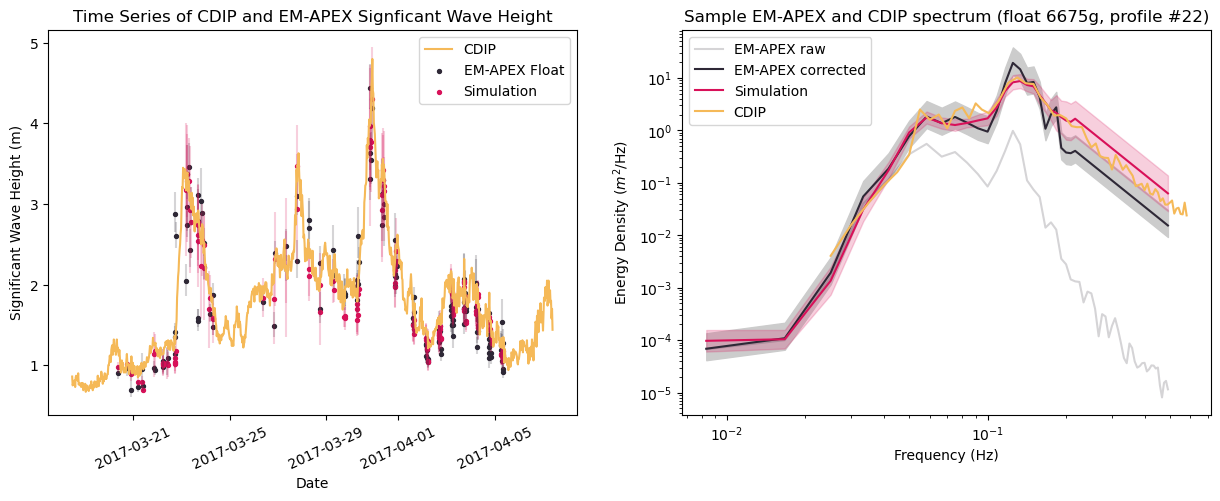

In [11]:
#First getting the 

t_apex_uniques = np.array([])
for t in t_apex_fake:
    if t in t_apex_uniques:
        continue
    else:
        t_apex_uniques = np.append(t_apex_uniques, [t])
        
Hs_means_sim = np.array([])
Hs_stds_sim = np.array([])
spec_store_means_sim = np.zeros((len(t_apex_uniques), len(fwindow_fake)))
spec_store_stds_sim = np.zeros((len(t_apex_uniques), len(fwindow_fake)))
counter=0
for t in t_apex_uniques:
    inds = np.where(t_apex_fake==t)
    avg_sim = np.nanmean(Hs_fake_angs_speed[inds])
    stdeviation_sim = np.nanstd(Hs_fake_angs_speed[inds])
    Hs_means_sim = np.append(Hs_means_sim, [avg_sim])
    Hs_stds_sim = np.append(Hs_stds_sim, [stdeviation_sim])

    spec_store_means_sim[counter, :] = np.nanmean(spec_store_sorted_new_corr_fake[inds[0], :], axis=0)
    spec_store_stds_sim[counter, :] = (spec_store_means_sim[counter, :]+2*np.nanstd(spec_store_sorted_new_corr_fake[inds[0], :], axis=0))/spec_store_means_sim[counter, :]
    counter+=1

#Replotting as above



ind=22
plt.figure(figsize=(15,5))
plt.subplot(122)
plt.fill_between(fwindow[1:],spec_store_sorted_new_corr[ind, :]*uncertainty_store_sorted[ind, 1],spec_store_sorted_new_corr[ind, :]*uncertainty_store_sorted[ind, 0],color='0.8')
plt.loglog(fwindow[1:], spec_store_sorted_new_raw[ind, :], label="EM-APEX raw", color=gray_color, alpha=0.2)
plt.loglog(fwindow[1:], spec_store_sorted_new_corr[ind, :], label="EM-APEX corrected", color=gray_color)
plt.loglog(fwindow[1:], spec_store_means_sim[ind, :], label="Simulation", color=red_color)
plt.fill_between(fwindow[1:],spec_store_means_sim[ind, :]/spec_store_stds_sim[ind, :],spec_store_means_sim[ind, :]*spec_store_stds_sim[ind, :],color=red_color, alpha=0.2)


plt.xlabel("Frequency (Hz)")
plt.ylabel(r"Energy Density ($m^2$/Hz)")

ind2 = np.where(np.abs(t_apex[ind]-ts)==np.min(np.abs(t_apex[ind]-ts)))
plt.loglog(wave_freq, energy_density[ind2[0][0], :], label="CDIP", color=cdip_color)


plt.legend()

plt.title("Sample EM-APEX and CDIP spectrum (float 6675g, profile #22)")
print(prof_store_sorted[ind])

plt.subplot(121)
plt.scatter(t_apex, Hs_corr, color=gray_color, s=8, label='EM-APEX Float')
plt.scatter(t_apex_uniques, Hs_means_sim, color=red_color, s=8, label='Simulation', )
plt.errorbar(t_apex, Hs_corr, yerr = errors, color=gray_color, alpha=0.2, fmt='none')
plt.errorbar(t_apex_uniques, Hs_means_sim, yerr = 2*Hs_stds_sim, color=red_color, alpha=0.2, fmt='none')

plt.plot(ts, Hs_cdip, label='CDIP', color='#F5B958')

#plt.scatter(swift_t_out, swift_arr[:, 3], s=6, alpha=0.2, color='k')

plt.ylabel("Significant Wave Height (m)")
plt.xlabel('Date')
plt.xticks( rotation=25 )
plt.title("Time Series of CDIP and EM-APEX Signficant Wave Height")
plt.legend()
#plt.savefig("/Users/jamesstadler/Documents/UW/TFO/Figures/LCDRI/JTECH_Paper/Timeseries_spectrum_w_sim.png", bbox_inches='tight')

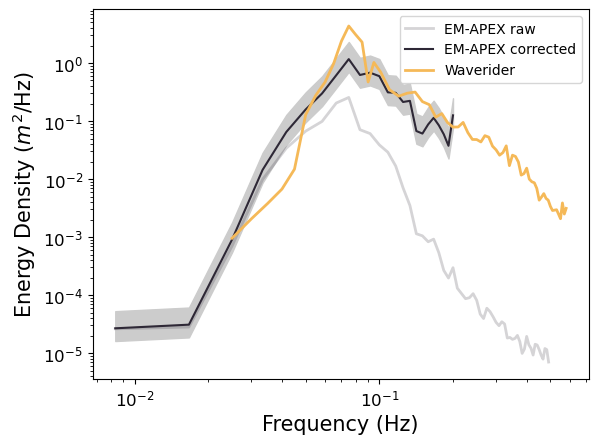

In [14]:
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)
plt.fill_between(fwindow[1:],spec_store_sorted[ind, 1, :]*uncertainty_store_sorted[ind, 1],spec_store_sorted[ind, 1, :]*uncertainty_store_sorted[ind, 0],color='0.8')
plt.loglog(fwindow[1:], spec_store_sorted_new_raw[ind, :], label="EM-APEX raw", color=gray_color, alpha=0.2, linewidth=2)
plt.loglog(fwindow[1:], spec_store_sorted[ind, 1, :], label="EM-APEX corrected", color=gray_color)



ind2 = np.where(np.abs(t_apex[ind]-ts)==np.min(np.abs(t_apex[ind]-ts)))
plt.loglog(wave_freq, energy_density[ind2[0][0], :], label="Waverider", color=cdip_color, linewidth=2)
plt.xlabel("Frequency (Hz)", fontsize=15)
plt.ylabel(r"Energy Density ($m^2$/Hz)", fontsize=15)
plt.legend()


In [20]:
#np.where(np.abs(t_apex[num]-swift_t_out)<datetime.timedelta(hours=1))
tbin = np.array([], dtype='int')
t_store_tbinned = np.array([])
spec_store_tbinned = np.array([])
for t_ind in range(len(t_apex)):
    if not np.any(tbin):
        tbin = np.append(tbin, int(t_ind))
    else:
        if t_apex[t_ind]-t_apex[tbin[0]]<datetime.timedelta(minutes=30):
            tbin = np.append(tbin, int(t_ind))
            
        else:
            #Average the spectra with teh right bin indicies?
            #temp spec should be [1, 59]
            temp_spec = np.nanmean(spec_store_sorted[tbin, 1, :], axis=0)
            mid_t = tbin[0]+(tbin[-1]-tbin[0])//2
            temp_t = t_apex[mid_t]
            tbin  = np.array([], dtype='int')
            
            if not np.any(spec_store_tbinned):
                spec_store_tbinned = np.expand_dims(temp_spec, axis=0)
                t_store_tbinned = temp_t
            else:
                spec_store_tbinned = np.append(spec_store_tbinned, np.expand_dims(temp_spec, axis=0), axis=0)
                t_store_tbinned = np.append(t_store_tbinned, temp_t)

/var/folders/77/7yfflvs902s95j6rlhb5yn9c0000gn/T/ipykernel_57520/3364392660.py:15: RuntimeWarning: Mean of empty slice
  temp_spec = np.nanmean(spec_store_sorted[tbin, 1, :], axis=0)


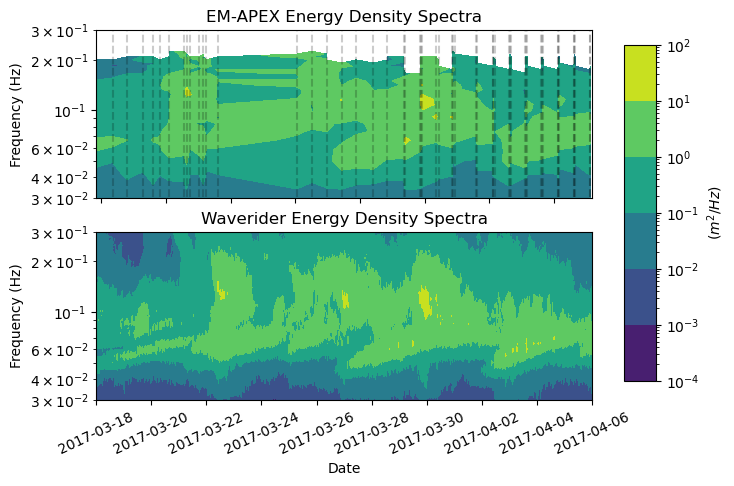

In [29]:

from matplotlib import cm, ticker

fig, axes = plt.subplots(nrows=2, ncols=1)

#For getting uniformly-spaced x-axis
xtick_times = ts[0::100]

#p#lt.subplot(211)
ax1=axes[0]
ax2=axes[1]
ax1.contourf(t_store_tbinned, fwindow[1:], spec_store_tbinned.T, locator=ticker.LogLocator(), vmin=10**-4, vmax=10**2)

ax1.tick_params(
    axis='x',          # changes apply to the x-axis        # ticks along the top edge are off
    labelbottom=False)
ax1.vlines(x=t_store_tbinned, ymin=0, ymax=0.3, color='k', linestyle='--', alpha=0.2)
ax1.set_ylim([0.03, 0.3])
ax1.set_yscale('log')
ax1.set_ylabel("Frequency (Hz)")
ax1.set_title("EM-APEX Energy Density Spectra")
#ax1.colorbar()
ax1.xaxis.set_ticks(xtick_times) #set the ticks to be uniform
ax1.set_xlim([t_apex[0], t_apex[-1]])


#plt.subplot(212)
im = ax2.contourf(ts, wave_freq, energy_density.T, locator=ticker.LogLocator(), vmin=10**-4, vmax=10**2)

ax2.set_ylim([0.03, 0.3])
ax2.set_yscale('log')
#plt.colorbar()
ax2.set_xlim([t_apex[0], t_apex[-1]])
ax2.set_xlabel('Date')
ax2.set_ylabel("Frequency (Hz)")
ax2.set_title("Waverider Energy Density Spectra")
ax2.xaxis.set_ticks(xtick_times) #set the ticks to be uniform


# Rotating X-axis labels
for tick in ax2.get_xticklabels():
    tick.set_rotation(25)

cbar_ax = fig.add_axes([0.95, 0.15, 0.05, 0.7])
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.set_label(r'$(m^2/Hz)$', rotation=90, loc='center')
plt.savefig("/Users/jamesstadler/Documents/UW/TFO/Figures/LCDRI/JTECH_Paper/spectra_tseries.png", bbox_inches='tight')

In [26]:
len(ts)

958

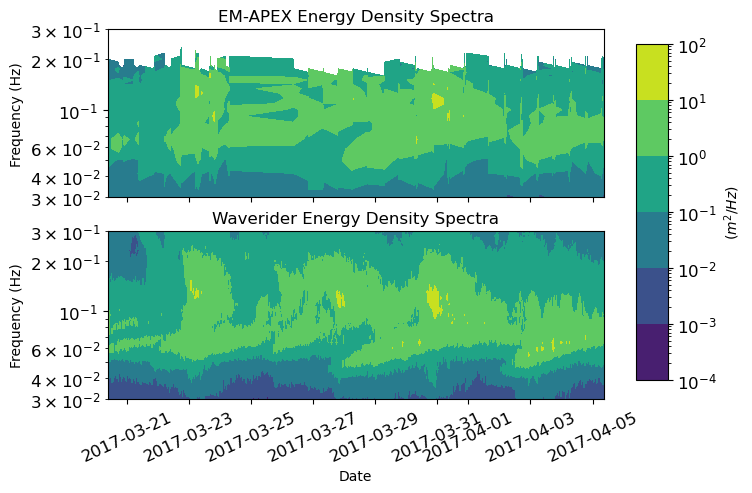

In [17]:
from matplotlib import cm, ticker

fig, axes = plt.subplots(nrows=2, ncols=1)

#p#lt.subplot(211)
ax1=axes[0]
ax2=axes[1]
ax1.contourf(t_apex, fwindow[1:], spec_store_sorted[:, 1, :].T, locator=ticker.LogLocator(), vmin=10**-4, vmax=10**2)

ax1.tick_params(
    axis='x',          # changes apply to the x-axis        # ticks along the top edge are off
    labelbottom=False)
ax1.set_ylim([0.03, 0.3])
ax1.set_yscale('log')
ax1.set_ylabel("Frequency (Hz)")
ax1.set_title("EM-APEX Energy Density Spectra")
#ax1.colorbar()


#plt.subplot(212)
im = ax2.contourf(ts, wave_freq, energy_density.T, locator=ticker.LogLocator(), vmin=10**-4, vmax=10**2)

ax2.set_ylim([0.03, 0.3])
ax2.set_yscale('log')
#plt.colorbar()
ax2.set_xlim([t_apex[0], t_apex[-1]])
ax2.set_xlabel('Date')
ax2.set_ylabel("Frequency (Hz)")
ax2.set_title("Waverider Energy Density Spectra")
# Rotating X-axis labels
for tick in ax2.get_xticklabels():
    tick.set_rotation(25)

cbar_ax = fig.add_axes([0.95, 0.15, 0.05, 0.7])
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.set_label(r'$(m^2/Hz)$', rotation=90, loc='center')

In [8]:
#Loop for saving out each spectrum (with error bounds)
#ind = 1
for ind in range(0, len(Hs_corr)):
    plt.figure()
    plt.loglog(fwindow[1:], spec_store_sorted_new_raw[ind, :], label="EM-APEX raw")
    plt.loglog(fwindow[1:], spec_store_sorted_new_corr[ind, :])
    plt.xlabel("Frequency (Hz)")
    plt.ylabel(r"Energy Density ($m^2$/Hz)")
    #plt.loglog(np.log(fwindow[1:]), p(np.log(fwindow[1:])))
    #a = np.exp(fit[1])
    #b = -2#fit[0]
    #a = spec_store_sorted_new_raw[ind, 0]/np.exp(b * np.log(fwindow[1]))
    #y_fitted = a * np.exp(b * np.log(fwindow[1:]))

    #plt.loglog(fwindow[1:], y_fitted)
    #plt.loglog(fwindow[1:], spec_store_sorted_new_raw[-4, :]-y_fitted)
    ind2 = np.where(np.abs(time_store_sorted[ind]-times)==np.min(np.abs(time_store_sorted[ind]-times)))
    plt.loglog(wave_freq, energy_density[ind2[0][0], :], label="CDIP")


    #practice getting a high frequency fit
    #end_ind = np.where(np.isnan(spec_store_sorted_new_corr[ind, :]))[0][0]-1
    #f_end = fwindow[1+end_ind]
    #E_end = spec_store_sorted_new_corr[ind, end_ind]
    #b = np.log10(E_end)+5*np.log10*
    #c = E_end/f_end**(-4)
    #extension = np.power(fwindow[1:], -4)*c
    #extension[:end_ind]=0
    #temp_spec = np.copy(spec_store_sorted_new_corr[ind, :])
    #temp_spec[end_ind:]=0
    #plt.loglog(fwindow[1:], extension)

    #PLot highfrequency fit
    plt.loglog(fwindow[1:], spec_store_sorted_new_corr[ind, :], label="EM-APEX corrected")
    plt.fill_between(fwindow[1:],spec_store_sorted_new_corr[ind, :]*uncertainty_store_sorted[ind, 1],spec_store_sorted_new_corr[ind, :]*uncertainty_store_sorted[ind, 0],color='0.8')
    plt.legend()
    if up_down_store_sorted[ind]:
        plt.title("Prof # "+str(ind)+" (up)")
    else:
        plt.title("Prof # "+str(ind)+" (down)")

    plt.savefig("/Users/jamesstadler/Documents/UW/TFO/Figures/LCDRI/EmApex_spectra/prof_"+f'{ind:03}'+".png", bbox_inches='tight')

    plt.close()
    #print(Hs[ind])
   # print(Hs_cdip[ind2])
    #print(extended_swh)
    
    #extended_spec.shape
    #print(spec_store_sorted_new_corr.shape)
    #print(up_down_store_sorted[ind])

Text(0.5, 1.0, 'Swift vs. CDIP signficant wave heights')

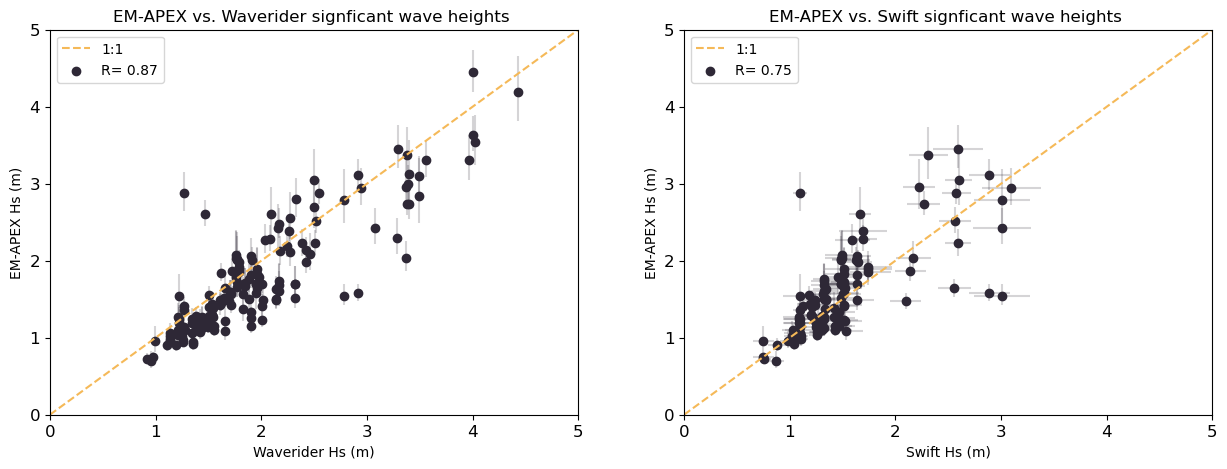

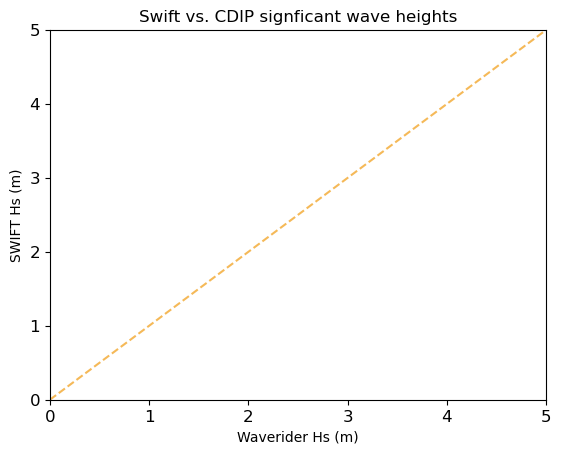

In [18]:
#Load SWIFT Data
##TO DO: Get distances for each thing


cdip_inds = np.array([], dtype=int)
for ind in range(0, len(time_store_sorted)):
    ind2 = np.where(np.abs(time_store_sorted[ind]-times)==np.min(np.abs(time_store_sorted[ind]-times)))
    #plt.loglog(wave_freq, energy_density[ind2[0][0], :], label="CDIP")
    cdip_inds = np.append(cdip_inds, ind2[0])

    
    
    



# swift_folder = "/Users/jamesstadler/Documents/UW/TFO/Data/LCDRI/SWIFT/SWIFTprocessed/"

# files = os.listdir(swift_folder)
# swift_loc_storer = {}
# swift_arr = np.array([[0,0,0,0]])

# for file in files:
#     lat_arr = np.array([])
#     lon_arr = np.array([])
#     swift_fname = swift_folder+file
#     name_tag = swift_fname.split('.')[0]
#     SWIFT = loadmat(swift_fname)

#     swift = np.transpose(SWIFT['SWIFT'])
#     if swift.size==0:
#         continue
#     else:
#         mdtype = swift.dtype
#         ndata = {n: swift[n] for n in mdtype.names}
#         columns = [n for (n, v) in ndata.items()]
#         df = pd.DataFrame(np.concatenate([ndata[c] for c in columns], axis=1, dtype='object'), columns=columns)
#         lat=np.array(df['lat'], dtype=float)
#         lon=np.array(df['lon'], dtype=float)
#         time = np.array(df['time'], dtype=float)
#         hs = np.array(df['sigwaveheight'], dtype=float)
#         lat_arr = np.expand_dims(lat, axis=1)
#         lon_arr = np.expand_dims(lon, axis=1)
#         time_arr = np.expand_dims(time, axis=1)
#         hs_arr = np.expand_dims(hs, axis=1)

#         swift_temp_arr = np.hstack((time_arr, lon_arr, lat_arr, hs_arr))
#         swift_arr = np.vstack((swift_arr, swift_temp_arr))
    

# swift_arr = np.delete(swift_arr, 0, 0)

all_swift_file = "/Users/jamesstadler/Documents/UW/TFO/Data/LCDRI/SWIFT/testswiftnew.mat"

SWIFT_new = loadmat(all_swift_file)
swift_arr = np.array([[0,0,0,0, 0]])
for i in range(len(SWIFT_new['swift'][0, 0])):
    lat_arr = np.array([])
    lon_arr = np.array([])
    swift_temp = SWIFT_new['swift'][0, 0][i]
    #time = swift_temp[0, 0][0][0]
    #lon = swift_temp[0, 0][1][0]
    #lat = swift_temp[0, 0][2][0]
    #wavesigH = swift_temp[0, 0][9][0]
    mdtype = swift_temp.dtype
    ndata = {n: swift_temp[n] for n in mdtype.names}
    columns = [n for (n, v) in ndata.items()]
    df = pd.DataFrame(np.concatenate([ndata[c] for c in columns], axis=1, dtype='object'), columns=columns)
    lat=np.array(df['lat'][0], dtype=float).T
    lon=np.array(df['lon'][0], dtype=float).T
    time = np.array(df['time'][0], dtype=float).T
    hs = np.array(df['wavesigH'][0], dtype=float).T
    wave_dir = np.array(df['wavepeakdir'][0], dtype=float).T
    #lat_arr = np.expand_dims(lat, axis=1)
    #lon_arr = np.expand_dims(lon, axis=1)
    #time_arr = np.expand_dims(time, axis=1)
    #hs_arr = np.expand_dims(hs, axis=1)

    swift_temp_arr = np.hstack((time, lon, lat, hs, wave_dir))
    swift_arr = np.vstack((swift_arr, swift_temp_arr))

swift_arr = np.delete(swift_arr, 0, 0)

#swift_arr2=swift_arr2[swift_arr[:, 0].argsort()]
swift_arr = swift_arr[swift_arr[:, 0].argsort()]

swift_t_out=datenum_to_datetime(swift_arr[:, 0])
swift_mean_store = np.array([], dtype=int)
swift_std_store = np.array([], dtype=int)
apex_swift_inds = np.array([], dtype=int)
swift_dists = np.array([], dtype=int)
counter = 0
for t in t_apex:
    blah = np.where(np.abs(t-swift_t_out)<datetime.timedelta(hours=1))
    if blah[0].size==0:
        counter+=1
        continue
    else:
        ind = np.where(t==t_apex)
        lat = loc_store_sorted[ind, 0]
        lon = loc_store_sorted[ind, 1]
        swift_mean_store = np.append(swift_mean_store, np.nanmean(swift_arr[blah, 3]))
        swift_std_store = np.append(swift_std_store, np.nanstd(swift_arr[blah, 3]))
        dists = np.zeros(len(blah[0]))
        for blah_i in range(len(blah[0])):
            dists[blah_i] = np.array(haversine.haversine((lat, lon), (swift_arr[blah[0][blah_i], 2], swift_arr[blah[0][blah_i], 1]), normalize=True, unit=haversine.Unit.KILOMETERS))

        swift_dists = np.append(swift_dists, np.nanmin(dists))
        apex_swift_inds = np.append(apex_swift_inds, counter)
    counter+=1
    

    
#Calculate distances to CDIP
#Get distances from buoy to floats
dist=np.array([])
import haversine
for ind in range(loc_store_sorted.shape[0]):
    lat = loc_store_sorted[ind, 0]
    lon = loc_store_sorted[ind, 1]
    #if lat==0:
    #    continue
    #In meters
    dist = np.append(dist, np.array(haversine.haversine((lat, lon), (cdip_lat, cdip_lon), normalize=True, unit=haversine.Unit.KILOMETERS)))
    
    
#Calculate some fits 
x=np.arange(0, 6, 0.1)
[coef, resid, rank, sing, rcond] = np.polyfit(Hs_cdip[cdip_inds], Hs_corr,1, full=True)
poly1d_fn = np.poly1d(coef) 
# poly1d_fn is now a function which takes in x and returns an estimate for y

#'--k'=black dashed line, 'yo' = yellow circle marker    
    
#Calculate Pearson R value
cdip_R = np.corrcoef(Hs_cdip[cdip_inds], Hs_corr)
swift_R = np.corrcoef(swift_mean_store, Hs_corr[apex_swift_inds])
    
    
#Plot the EM-APEX vs. Swift data
import matplotlib.gridspec as gridspec

# Create 2x2 sub plots
gs = gridspec.GridSpec(1, 2)



plt.figure(figsize=(15,5))



#plt.subplot(121)
ax = plt.subplot(gs[0, 0]) # row 0, col 0
ax.errorbar(Hs_cdip[cdip_inds], Hs_corr, yerr = errors, c=gray_color, alpha=0.2, fmt='none')
#ax.scatter(Hs_cdip[cdip_inds], Hs_corr[ups], c=dist[ups], cmap="magma")
ax.scatter(Hs_cdip[cdip_inds], Hs_corr, c=gray_color, label="R= "+"{:.2f}".format( cdip_R[0, 1] ))
#ax.plot(x, poly1d_fn(x), '--k') 
#ax.errorbar(Hs_cdip[cdip_inds_down], Hs_corr[downs], yerr = errors[:, downs], c=gray_color, alpha=0.2, fmt='none')
#im = ax.scatter(Hs_cdip[cdip_inds], Hs_corr, c=dist, cmap="magma")
#ax.scatter(Hs_cdip[cdip_inds_down], Hs_corr[downs], c=gray_color)
#plt.colorbar(im, ax=ax)
#plt.colorbar(im, ax=ax)

y = np.arange(0, 6, 0.1)
ax.plot(np.arange(0, 6, 0.1), y, '--',color=cdip_color, label="1:1")
ax.set_xlim([0, 5])
ax.set_ylim([0, 5])
ax.set_xlabel("Waverider Hs (m)")
ax.set_ylabel("EM-APEX Hs (m)")
ax.set_title("EM-APEX vs. Waverider signficant wave heights ")
ax.legend()


#plt.subplot(122)
ax = plt.subplot(gs[0, 1]) # row 0, col 1


ax.errorbar(swift_mean_store, Hs_corr[apex_swift_inds], yerr = errors[:, apex_swift_inds], xerr=swift_std_store, color=gray_color, alpha=0.2, fmt='none')
ax.scatter(swift_mean_store, Hs_corr[apex_swift_inds], color=gray_color, label="R= "+"{:.2f}".format( swift_R[0, 1] ))
#im = ax.scatter(swift_mean_store, Hs_corr[apex_swift_inds], c=cdip_apex_diff, cmap="magma")


y = np.arange(0, 6, 0.1)
ax.plot(np.arange(0, 6, 0.1), y, '--',color=cdip_color, label="1:1")
ax.set_xlim([0, 5])
ax.set_ylim([0, 5])
ax.set_xlabel("Swift Hs (m)")
ax.set_ylabel("EM-APEX Hs (m)")
ax.set_title("EM-APEX vs. Swift signficant wave heights ")
ax.legend()
plt.savefig("/Users/jamesstadler/Documents/UW/TFO/Figures/LCDRI/JTECH_Paper/Hs_scatter.png")

swift_arr = swift_arr[swift_arr[:, 0].argsort()]
cdip_timestamp = [temp_t.timestamp() for temp_t in ts]
swift_timestamp = [s_temp.timestamp() for s_temp in datenum_to_datetime(swift_arr[:, 0])]

Hs_cdip_interped = np.interp(swift_timestamp, cdip_timestamp, Hs_cdip)
#Hs_cdip_interped = np.interp(cdip_timestamp, swift_timestamp, swift_arr[:, -1])

#ax = plt.subplot(gs[1, :]) # row 1, span all columnsata
plt.figure()
plt.scatter(Hs_cdip_interped, swift_arr[:, -1], color=gray_color)
#im = plt.scatter(Hs_cdip_interped, swift_arr[:, -1], c=apex_cdip_dist, cmap="magma")
#plt.colorbar(im)

#plt.errorbar(Hs_cdip_interped, swift_arr[:, -1], yerr=swift_std_store*2, color=gray_color)
plt.plot(np.arange(0, 6, 0.1), y, '--',color=cdip_color, label="1:1")
plt.xlim([0,5])
plt.ylim([0,5])

plt.xlabel("Waverider Hs (m)")
plt.ylabel("SWIFT Hs (m)")
plt.title("Swift vs. CDIP signficant wave heights")


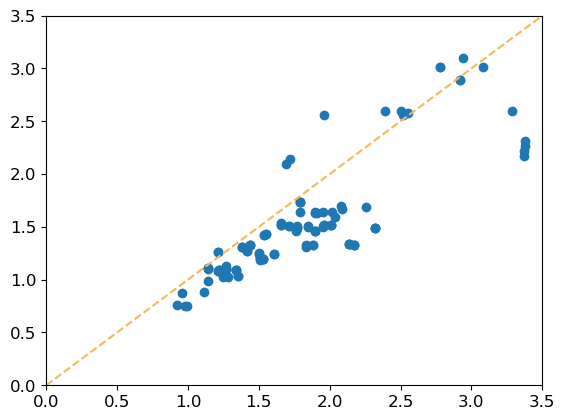

In [19]:
swift_mean_store = np.array([], dtype=int)
swift_std_store = np.array([], dtype=int)
apex_cdip_swift_inds = np.array([], dtype=int)
counter=0
apex_cdip_diff = np.zeros(len(cdip_inds))
for num in range(len(cdip_inds)):
    blah = np.where(np.abs(t_apex[num]-swift_t_out)<datetime.timedelta(hours=1))
    if blah[0].size==0:
        counter+=1
        #apex_cdip_swift_inds = np.append(apex_cdip_swift_inds, cdip_inds[num])
        apex_cdip_diff[num]=0
        continue
    else:

        swift_mean_store = np.append(swift_mean_store, np.nanmean(swift_arr[blah, 3]))
        swift_std_store = np.append(swift_std_store, np.nanstd(swift_arr[blah, 3]))


        apex_cdip_swift_inds = np.append(apex_cdip_swift_inds, cdip_inds[num])
        apex_cdip_diff[num] = np.abs(np.nanmean(swift_arr[blah, 3])-Hs_cdip[cdip_inds[num]])
    counter+=1
    
plt.scatter(Hs_cdip[apex_cdip_swift_inds], swift_mean_store)
plt.plot(np.arange(0, 6, 0.1), np.arange(0, 6, 0.1), '--',color=cdip_color, label="1:1")
plt.xlim([0, 3.5])
plt.ylim([0, 3.5])


cdip_apex_diff = np.abs(swift_mean_store-Hs_cdip[apex_cdip_swift_inds])

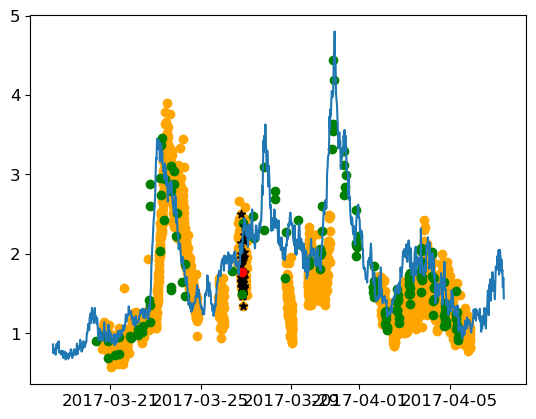

In [20]:
plt.plot(ts, Hs_cdip)
#plt.scatter(swift_timestamp, Hs_cdip_interped, color='green')
plt.scatter(swift_t_out, swift_arr[:, 3], color='orange', label="Swift measurements")
plt.scatter(t_apex, Hs_corr, color='green')
test_ind = 38
swift_inds = np.where(np.abs(t_apex[test_ind]-swift_t_out)<datetime.timedelta(hours=2))[0]
plt.scatter(swift_t_out[swift_inds], swift_arr[swift_inds, 3], color='k', marker='*')
plt.scatter(t_apex[test_ind], np.nanmean(swift_arr[swift_inds, 3]), color='red')
plt.scatter(t_apex[test_ind], Hs_corr[test_ind], color='green')
#plt.scatter(time_store_sorted[apex_swift_inds], Hs_cdip[apex_cdip_swift_inds], color='red')

In [21]:
#Save a bunch of these arrays

np.savez("/Users/jamesstadler/Documents/UW/TFO/Data/LCDRI/intermediate_processed_data/hs_data", errors = errors, swift_t = swift_t_out, swift_arr=swift_arr, t_apex=t_apex, Hs_corr=Hs_corr, Hs_cdip=Hs_cdip, loc_store_sorted=loc_store_sorted, ts=ts, Te_cdip = Te_cdip_cutoff, Te=Te_cutoff, peak_freq_cdip=peak_freq_cdip, peak_freq=peak_freq)

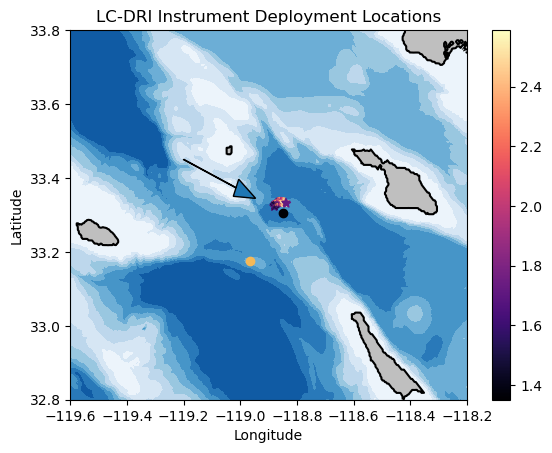

In [12]:
#Load Bathymetry

#TID is not actually the z-depth, need to download a correct version of this bathymetry
bath_fname = '/Users/jamesstadler/Documents/UW/TFO/Data/LCDRI/gebco_2022_soCal.nc'
nc = netcdf.NetCDFFile(bath_fname, 'r', mmap=False) #Not sure why I need to do mmap = False but it gets rid of a warning
bath_lat= nc.variables['lat'][:]
bath_lon = nc.variables['lon'][:]
bath_z = nc.variables['elevation'][:]
#print(nc.variables)

minz=-1500
maxz=0

bath_z[bath_z<minz]=minz
bath_z[bath_z>maxz]=maxz

from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1 import make_axes_locatable

import matplotlib.patches as patches


fig, (ax) = plt.subplots(1, 1)
plt.title("LC-DRI Instrument Deployment Locations")
pc = ax.contourf(bath_lon, bath_lat, bath_z, cmap = 'Blues_r', vmin=-1800, vmax=0)
ax.contour(bath_lon,bath_lat,bath_z, levels=[-1], linestyles='solid', colors='k')
ax.contourf(bath_lon,bath_lat,bath_z, levels=[-2, 0], cmap='binary', vmin=-2, vmax=2)

ax.set_ylabel("Latitude")
ax.set_xlabel("Longitude")
ax.set_xlim([-119.6, -118.2])
ax.set_ylim([32.8, 33.8])
im = ax.scatter(swift_arr[swift_inds, 1]-360, swift_arr[swift_inds, 2], c=swift_arr[swift_inds, 3], marker='*', cmap='magma')
ax.scatter(loc_store_sorted[test_ind, 1], loc_store_sorted[test_ind, 0], c=Hs_corr[test_ind], cmap='magma')
ax.scatter(cdip_lon, cdip_lat, color=cdip_color)
#ax.scatter(-118.9, 33.2, color='k')
plt.colorbar(im, ax=ax)
plt.arrow(-119.2, 33.45, -(1/5)*np.sin(np.nanmean(swift_arr[:, 4])), (1/5)*np.cos(np.nanmean(swift_arr[:, 4])), head_width=0.05)

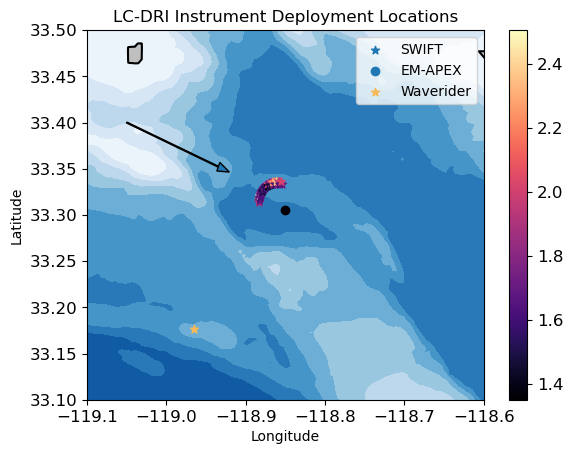

In [63]:

fig, (ax) = plt.subplots(1, 1)
plt.title("LC-DRI Instrument Deployment Locations")
pc = ax.contourf(bath_lon, bath_lat, bath_z, cmap = 'Blues_r', vmin=-1800, vmax=0)
ax.contour(bath_lon,bath_lat,bath_z, levels=[-1], linestyles='solid', colors='k')
ax.contourf(bath_lon,bath_lat,bath_z, levels=[-2, 0], cmap='binary', vmin=-2, vmax=2)

ax.set_ylabel("Latitude")
ax.set_xlabel("Longitude")
ax.set_xlim([-119.1, -118.6])
ax.set_ylim([33.1, 33.5])
im = ax.scatter(swift_arr[swift_inds, 1]-360, swift_arr[swift_inds, 2], c=swift_arr[swift_inds, 3], marker='*', cmap='magma', label="SWIFT")
ax.scatter(loc_store_sorted[test_ind, 1], loc_store_sorted[test_ind, 0], c=Hs_corr[test_ind], cmap='magma', label="EM-APEX")
ax.scatter(cdip_lon, cdip_lat, color=cdip_color, marker='*', label="Waverider")
#ax.scatter(-118.9, 33.2, color='k')
plt.colorbar(im, ax=ax)
plt.arrow(-119.05, 33.4, -(1/8)*np.sin(np.nanmean(swift_arr[:, 4])), (1/8)*np.cos(np.nanmean(swift_arr[:, 4])), head_width=0.01)
plt.legend()

In [20]:
print(np.corrcoef(Hs_cdip[cdip_inds], Hs_corr))
print(np.corrcoef(swift_mean_store, Hs_corr[apex_swift_inds]))
print(np.corrcoef(Hs_cdip_interped, swift_arr[:, -1]))


#Swift Bias 
print(np.nanmean(Hs_corr[apex_swift_inds]-swift_mean_store))

[[1.         0.87138741]
 [0.87138741 1.        ]]
[[1.         0.74687916]
 [0.74687916 1.        ]]
[[ 1. nan]
 [nan nan]]
0.09009493045266465


In [49]:
#Calculate mean difference and error bars
sigma = np.nanmean(errors, axis=0)
sigma_mean = np.sqrt(np.sum(np.square(sigma)))


In [60]:
#Get RMSE
rmse = np.nanstd(errs)/np.sqrt(len(errs))



swift_rmse = np.nanstd(Hs_corr[apex_swift_inds]-swift_mean_store)/np.sqrt(len(swift_mean_store))
print("Waverider rms = ", rmse*np.sqrt(len(errs)))
print("Waverider rmse = ", rmse)
print("SWIFT rmse = ", swift_rmse)
print("SWIFT rms = ", swift_rmse*np.sqrt(len(swift_mean_store)))

Waverider rms =  0.37170216011664176
Waverider rmse =  0.030248692800323263
SWIFT rmse =  0.0384059707538293
SWIFT rms =  0.41364496417471713


In [49]:
#Get distances from buoy to floats
dist=np.array([])

import haversine
for ind in range(loc_store_sorted.shape[0]):
    lat = loc_store_sorted[ind, 0]
    lon = loc_store_sorted[ind, 1]
    #if lat==0:
    #    continue
    #In meters
    dist = np.append(dist, np.array(haversine.haversine((lat, lon), (cdip_lat, cdip_lon), unit=haversine.Unit.KILOMETERS)))
apex_cdip_dist = np.array([])    
for ind in range(swift_arr.shape[0]):
    lat = swift_arr[ind, 2]
    lon = swift_arr[ind, 1]
    
    apex_cdip_dist = np.append(apex_cdip_dist, np.array(haversine.haversine((lat, lon), (cdip_lat, cdip_lon), normalize=True, unit=haversine.Unit.KILOMETERS)))

In [50]:
len(apex_cdip_dist)

2568

Text(0, 0.5, 'EM-APEX Mean Spectral level $(m^2/Hz)$')

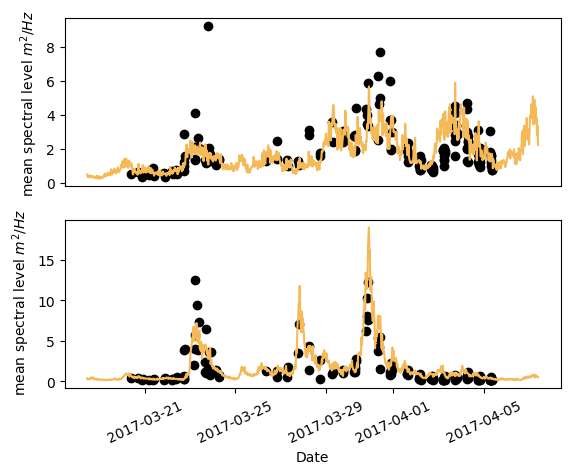

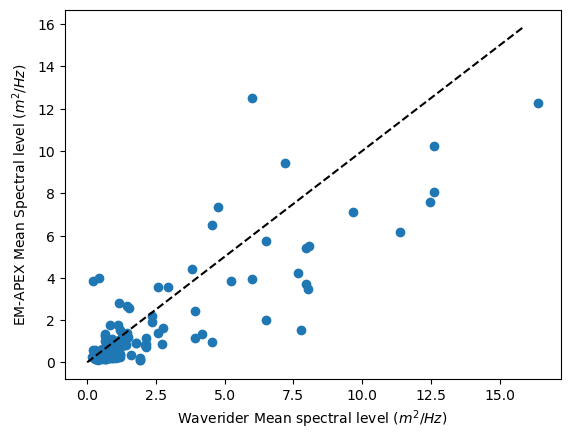

In [64]:
swell_b = [0.05, 0.1]
wind_b = [0.1, 0.14]
em_apex_swell_inds_s = np.where(fwindow[1:]>swell_b[0])[0][0] 
em_apex_swell_inds_e = np.where(fwindow[1:]<swell_b[1])[0][-1]

cdip_swell_inds_s = np.where(wave_freq>swell_b[0])[0][0] 
cdip_swell_inds_e = np.where(wave_freq<swell_b[1])[0][-1]

em_apex_wind_inds_s = np.where(fwindow[1:]>wind_b[0])[0][0] 
em_apex_wind_inds_e = np.where(fwindow[1:]<wind_b[1])[0][-1]

cdip_wind_inds_s = np.where(wave_freq>wind_b[0])[0][0] 
cdip_wind_inds_e = np.where(wave_freq<wind_b[1])[0][-1]

#spec_store_sorted[:, 1, :]
#fwindow[em_apex_swell_inds_s+1]
plt.subplot(211)
plt.scatter(t_apex, np.nanmean(spec_store_sorted[:, 1, em_apex_swell_inds_s+1:em_apex_swell_inds_e+2], axis=1), color='k')
plt.plot(ts, np.nanmean(energy_density[:, cdip_swell_inds_s:cdip_swell_inds_e+1], axis=1), color=cdip_color)
#plt.xlabel('Date')
plt.xticks( [] )
plt.ylabel(r"mean spectral level $m^2 / Hz$")
plt.subplot(212)
plt.scatter(t_apex, np.nanmean(spec_store_sorted[:, 1, em_apex_wind_inds_s+1:em_apex_wind_inds_e+2], axis=1), color='k')
plt.plot(ts, np.nanmean(energy_density[:, cdip_wind_inds_s:cdip_wind_inds_e+1], axis=1), color=cdip_color)
plt.xlabel('Date')
plt.xticks( rotation=25 )
plt.ylabel(r" mean spectral level $m^2 / Hz$")




plt.figure()
plt.scatter(np.nanmean(energy_density[cdip_inds, cdip_wind_inds_s:cdip_wind_inds_e+1], axis=1), np.nanmean(spec_store_sorted[:, 1, em_apex_wind_inds_s+1:em_apex_wind_inds_e+2], axis=1), label="wind")
#plt.scatter(np.nanmean(energy_density[cdip_inds, cdip_swell_inds_s:cdip_swell_inds_e+1], axis=1), np.nanmean(spec_store_sorted[:, 1, em_apex_swell_inds_s+1:em_apex_swell_inds_e+2], axis=1), label="swell")
y = np.arange(0, 16, 0.1)
plt.plot(np.arange(0, 16, 0.1), y, '--',color='k', label="1:1")
plt.xlabel(r"Waverider Mean spectral level $(m^2/Hz)$")
plt.ylabel(r"EM-APEX Mean Spectral level $(m^2/Hz)$")

In [63]:
print(np.corrcoef(np.nanmean(energy_density[cdip_inds, cdip_wind_inds_s:cdip_wind_inds_e+1], axis=1), np.nanmean(spec_store_sorted[:, 1, em_apex_wind_inds_s+1:em_apex_wind_inds_e+2], axis=1)))
print(np.corrcoef(np.nanmean(energy_density[cdip_inds, cdip_swell_inds_s:cdip_swell_inds_e+1], axis=1), np.nanmean(spec_store_sorted[:, 1, em_apex_swell_inds_s+1:em_apex_swell_inds_e+2], axis=1)))


[[1.         0.84575023]
 [0.84575023 1.        ]]
[[1.         0.44347005]
 [0.44347005 1.        ]]


In [131]:
up_locs = loc_store_sorted[ups]
loc = up_locs[-1]
import haversine
dist_arr =np.array([])
for pair in lon_lats[0, :, :]:

    dist = np.array(haversine.haversine((pair[1], pair[0]), (loc[0], loc[1])))
    dist_arr = np.append(dist_arr, dist)

In [2]:
 
swell_b = [0.05, 0.1]
wind_b = [0.1, 0.14]
em_apex_swell_inds_s = np.where(fwindow[1:]>swell_b[0])[0][0] 
em_apex_swell_inds_e = np.where(fwindow[1:]<swell_b[1])[0][-1]

cdip_swell_inds_s = np.where(wave_freq>swell_b[0])[0][0] 
cdip_swell_inds_e = np.where(wave_freq<swell_b[1])[0][-1]

[Hs_test,lower,upper] = sig_wave_height(fwindow[em_apex_swell_inds_s+1:em_apex_swell_inds_e+1], np.transpose(spec_store_sorted_new_corr[:, em_apex_swell_inds_s+1:em_apex_swell_inds_e+1]))
[Cdip_Hs_test, lower, upper] = sig_wave_height(wave_freq[cdip_swell_inds_s:cdip_swell_inds_e], np.transpose(energy_density[cdip_inds, cdip_swell_inds_s:cdip_swell_inds_e]))
plt.scatter(Hs_corr, Hs_test)
plt.scatter(Cdip_Hs_test, Hs_corr)
np.corrcoef(Cdip_Hs_test, Hs_corr)

NameError: name 'fwindow' is not defined

In [23]:
[AZoffs,AZ2offs,AZfits,AZ2fits,anghxhy, resid] = em_offset(Nfit,mlt_efr,nstep_off,navg_off,AZ,AZ,HX,HY)

In [28]:
Azr = AZ - np.nanmean(AZfits, axis=1)

/var/folders/77/7yfflvs902s95j6rlhb5yn9c0000gn/T/ipykernel_87066/2272138589.py:1: RuntimeWarning: Mean of empty slice
  Azr = AZ - np.nanmean(AZfits, axis=1)


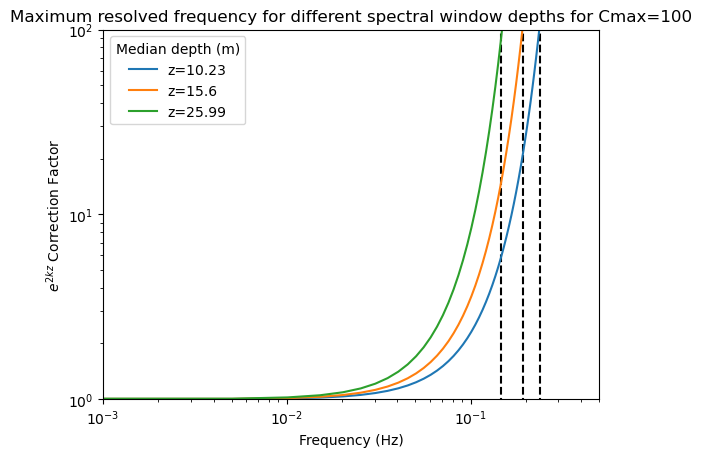

In [121]:
f = np.linspace(0, 0.5, 100)
k = np.square(2*np.pi*f)/9.8
z_arr = [6, 8, 10, 12, 16, 20, 24, 30]
z_arr = [12.78, 18.5]
z_arr = [10.23, 15.6, 25.99]
max_freqs = np.zeros(len(z_arr))
counter=0
Cmax = 100
plt.figure()
plt.set_cmap('tab10')
for z in z_arr:
    plt.loglog(f, np.exp(2*k*z), label='z='+str(z))
    max_ind = np.where(np.abs(np.exp(2*k*z)-Cmax)==np.min(np.abs(np.exp(2*k*z)-Cmax)))
    plt.vlines(x=f[max_ind], ymin=0, ymax=Cmax, linestyle='--', color='k')
    max_freqs[counter]=f[max_ind]
    counter+=1
plt.ylim(1, Cmax)
plt.xlim(0.001, 0.5)
plt.legend(title="Median depth (m)")

plt.xlabel("Frequency (Hz)")
plt.ylabel(r'$e^{2kz}$ Correction Factor')

plt.title("Maximum resolved frequency for different spectral window depths for Cmax=100")

#NEED TO FIX COLORS, maybe try tab10 colormap?



#Attempt at doing a table with matplotlib
# fig, axs =plt.subplots(1,2, gridspec_kw={'width_ratios': [3, 1]}, figsize=(15, 11))

# for z in z_arr:
#     axs[0].loglog(f, np.exp(2*k*z), label='z='+str(z))
#     max_ind = np.where(np.abs(np.exp(2*k*z)-10)==np.min(np.abs(np.exp(2*k*z)-10)))
#     axs[0].vlines(x=f[max_ind], ymin=0, ymax=10, linestyle='--', color='k')
#     max_freqs[counter]=f[max_ind]
#     counter+=1
# axs[0].set_ylim(1, 10)
# axs[0].set_xlim(0.001, 0.3)
# axs[0].legend(title="Median depth (m)")

# axs[0].set_xlabel("Frequency (Hz)")
# axs[0].set_ylabel(r'$e^{2kz}$ Correction Factor')

# axs[0].set_title("Maximum resolved frequency for different spectral window depths for Cmax=10")

# # Add a table at the bottom of the axes
# the_table = axs[1].table(cellText=np.expand_dims(np.round(max_freqs, 2), axis=1),
#                       rowLabels=z_arr,
#                       colLabels = ["Max Frequency (Hz)"],
#                       bbox=[0, 0, 1, 1],
#                       fontsize=40)

# axs[1].axis("off")
plt.savefig("/Users/jamesstadler/Documents/UW/TFO/Figures/LCDRI/JTECH_Paper/DepthCorrection_Impact.png", bbox_inches='tight')


In [122]:
#list(np.char.mod('%f', max_freqs))
max_freqs

array([0.23737374, 0.19191919, 0.14646465])

In [17]:
max_freqs

array([0.30808081, 0.26767677, 0.23737374, 0.21717172, 0.18686869,
       0.16666667, 0.15656566, 0.13636364])

In [87]:
fname_base_profs = "/Users/jamesstadler/Documents/UW/TFO/Data/LCDRI/EmApex_Data/profs/"
float_list = os.listdir(fname_base_profs)
prof_times = np.array([])
for float_name in float_list:
    if '.DS_Store' not in float_name:
        mat_data = loadmat(fname_base_profs+float_name)
        prof_times_temp = mat_data['VEL']['jday_gmt'][0][0][0, :]
        prof_times = np.append(prof_times, prof_times_temp)

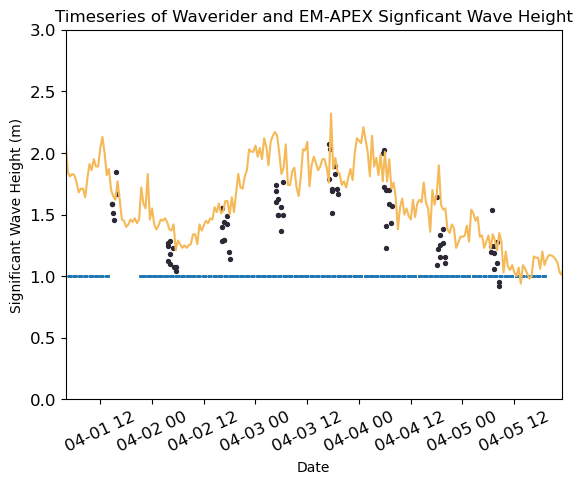

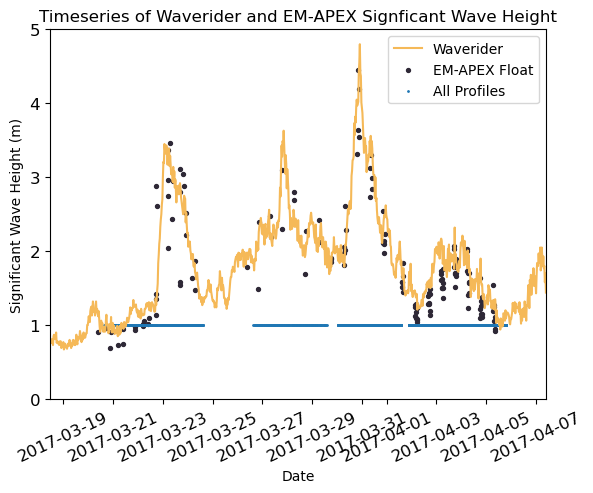

In [134]:
sorted_prof_times = np.sort(prof_times)
prof_dtimes = datenum_to_datetime(sorted_prof_times)# for t in sorted_prof_times])
lcdri = np.where(prof_dtimes)
#plt.scatter(prof_dtimes, np.ones(len(prof_times)), s=2, label="All Profiles")
plt.plot(ts, Hs_cdip, cdip_color, label="Waverider")
plt.xlim(ts[-300], ts[-70])
plt.scatter(t_apex, Hs_corr, color=gray_color, s=8, label='EM-APEX Float')
plt.xlabel('Date')
plt.xticks( rotation=25 )
plt.title("Timeseries of Waverider and EM-APEX Signficant Wave Height")
plt.ylabel("Significant Wave Height (m)")
plt.ylim([0, 3])
#plt.twinx()
plt.scatter(prof_dtimes, np.ones(len(prof_times)), s=1, label="All Profiles")
#plt.ylim([0.9, 2])
#plt.legend()
plt.figure()

plt.plot(ts, Hs_cdip, cdip_color, label="Waverider")
plt.xlim(ts[0], ts[-1])
plt.scatter(t_apex, Hs_corr, color=gray_color, s=8, label='EM-APEX Float')
plt.xlabel('Date')
plt.xticks( rotation=25 )
plt.title("Timeseries of Waverider and EM-APEX Signficant Wave Height")
plt.ylabel("Significant Wave Height (m)")
plt.ylim([0, 5])
#plt.legend()
#plt.twinx()
plt.scatter(prof_dtimes, np.ones(len(prof_times)), s=1, label="All Profiles")
#plt.ylim([0.9, 2])
plt.legend()

